## <프로젝트 유형: Multi-Step LSTM Time Series Forecasting>
* windows개념 이용해서 univariate time series forecasting의 방법으로 해결해보고자 함

In [ ]:
# Runned_by_Colab

# 1. 이번 Trial 내용
# ReduceLROnPlateau() factor  = 0.9, patience = 5
# earlystopping(patience = 10)
# input: 60, output: 1의 many-to-one 모델 <-얘가 핵심인듯?
# LSTM 층 하나 추가

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Library
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional#,Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read Data
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [ ]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(1380, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(1380, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

In [ ]:
# 모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
# LSTM에 return_sequence=True가 주어지고 Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형이 된다.https://m.blog.naver.com/chunjein/221589656211
# TimeDistributed() 함수 사용: 모델 layer에 model.add(TimeDistributed(Dense(1, activation='sigmoid')))추가

def build_model():
    seq_len = 60
    model = Sequential()
    # 첫 번째 layer에서 LSTM()매서드 안의 stateful = True는 오히려 다운 퍼포먼스 될 수 있음
    model.add(LSTM(100, activation='tanh', return_sequences= True, input_shape = [seq_len, 1])) 
#     model.add(Bidirectional(LSTM(50, activation='tanh', dropout=0.50, recurrent_dropout=0.25)))
    model.add(LSTM(50, activation='tanh', return_sequences= True))
    model.add(LSTM(50, activation= 'tanh'))
    model.add(Dense(1))  #60개의 open값 입력되어 121번째 open값 '하나' 예측   
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [ ]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LearningRateScheduler(scheduler) 구현

# from tensorflow.keras.callbacks import LearningRateScheduler
# # LearningRateScheduler 함수 생성 (epoch이 5이하면 그대로 lr 유지, 아닐시 lr 조정)
# def scheduler(epoch, learning_rate):
#     if epoch < 5:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr = LearningRateScheduler(scheduler)

In [ ]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) early_stoppage & reduceLR 정의: https://www.dacon.io/competitions/official/235709/codeshare/2453?page=1&dtype=recent 참고)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience= 5, min_lr=0)

# 3) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***
ep = 30
bs = 120
# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 60
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop, reduceLR])
# shuffle= True 효과 있을까? 미약하게나마 효과 있음. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 61), window.shape (60, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 60, 1)
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값을 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개 -> 118개 -> ***

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))   

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  6.704549014102668e-05
lr :  0.00066


  0%|          | 1/529 [00:18<2:45:08, 18.77s/it]

sample_id :  1 번
loss :  3.6761019146069884e-05
lr :  0.00066


  0%|          | 2/529 [00:30<2:27:02, 16.74s/it]

sample_id :  2 번
loss :  9.600525663699955e-05
lr :  0.00073


  1%|          | 3/529 [00:42<2:14:40, 15.36s/it]

sample_id :  3 번
loss :  7.505089888582006e-05
lr :  0.0009


  1%|          | 4/529 [00:55<2:06:01, 14.40s/it]

sample_id :  4 번
loss :  3.946772267227061e-05
lr :  0.00066


  1%|          | 5/529 [01:07<2:00:16, 13.77s/it]

sample_id :  5 번
loss :  0.00040634998003952205
lr :  0.00073


  1%|          | 6/529 [01:19<1:56:44, 13.39s/it]

sample_id :  6 번
loss :  0.0003308977175038308
lr :  0.00073


  1%|▏         | 7/529 [01:32<1:53:41, 13.07s/it]

sample_id :  7 번
loss :  0.00029512064065784216
lr :  0.00066


  2%|▏         | 8/529 [01:44<1:51:41, 12.86s/it]

sample_id :  8 번
loss :  0.00015920729492790997
lr :  0.00066


  2%|▏         | 9/529 [01:56<1:49:57, 12.69s/it]

sample_id :  9 번
loss :  0.0003115174768026918
lr :  0.00073


  2%|▏         | 10/529 [02:09<1:48:58, 12.60s/it]

sample_id :  10 번
loss :  0.00011871938477270305
lr :  0.00066


  2%|▏         | 11/529 [02:21<1:48:15, 12.54s/it]

sample_id :  11 번
loss :  0.00029168103355914354
lr :  0.00066


  2%|▏         | 12/529 [02:34<1:48:02, 12.54s/it]

sample_id :  12 번
loss :  4.583512054523453e-05
lr :  0.00066


  2%|▏         | 13/529 [02:46<1:47:34, 12.51s/it]

sample_id :  13 번
loss :  0.00013093824964016676
lr :  0.00066


  3%|▎         | 14/529 [02:59<1:47:04, 12.48s/it]

sample_id :  14 번
loss :  0.00024990152451209724
lr :  0.00066


  3%|▎         | 15/529 [03:11<1:46:33, 12.44s/it]

sample_id :  15 번
loss :  0.00017771941202227026
lr :  0.00066


  3%|▎         | 16/529 [03:23<1:46:24, 12.45s/it]

sample_id :  16 번
loss :  0.00010647423914633691
lr :  0.00066


  3%|▎         | 17/529 [03:36<1:46:14, 12.45s/it]

sample_id :  17 번
loss :  0.00029187145992182195
lr :  0.001


  3%|▎         | 18/529 [03:48<1:45:51, 12.43s/it]

sample_id :  18 번
loss :  0.00022494528093375266
lr :  0.00066


  4%|▎         | 19/529 [04:00<1:45:16, 12.39s/it]

sample_id :  19 번
loss :  0.0003370694175828248
lr :  0.00073


  4%|▍         | 20/529 [04:13<1:45:25, 12.43s/it]

sample_id :  20 번
loss :  0.0003369357727933675
lr :  0.00073


  4%|▍         | 21/529 [04:25<1:44:50, 12.38s/it]

sample_id :  21 번
loss :  0.00029179127886891365
lr :  0.001


  4%|▍         | 22/529 [04:38<1:44:23, 12.35s/it]

sample_id :  22 번
loss :  0.00014387043484020978
lr :  0.00066


  4%|▍         | 23/529 [04:50<1:43:37, 12.29s/it]

sample_id :  23 번
loss :  0.0001960692461580038
lr :  0.001


  5%|▍         | 24/529 [05:02<1:43:16, 12.27s/it]

sample_id :  24 번
loss :  0.00020202764426358044
lr :  0.00073


  5%|▍         | 25/529 [05:14<1:43:36, 12.34s/it]

sample_id :  25 번
loss :  0.0002252889098599553
lr :  0.001


  5%|▍         | 26/529 [05:27<1:43:08, 12.30s/it]

sample_id :  26 번
loss :  0.00015932640235405415
lr :  0.001


  5%|▌         | 27/529 [05:39<1:42:31, 12.25s/it]

sample_id :  27 번
loss :  0.00032582180574536324
lr :  0.00073


  5%|▌         | 28/529 [05:51<1:42:26, 12.27s/it]

sample_id :  28 번
loss :  0.00020657390996348113
lr :  0.001


  5%|▌         | 29/529 [06:03<1:41:38, 12.20s/it]

sample_id :  29 번
loss :  0.00012000439164694399
lr :  0.00066


  6%|▌         | 30/529 [06:15<1:41:08, 12.16s/it]

sample_id :  30 번
loss :  0.00016055317246355116
lr :  0.00066


  6%|▌         | 31/529 [06:27<1:40:49, 12.15s/it]

sample_id :  31 번
loss :  3.4811040677595884e-05
lr :  0.00066


  6%|▌         | 32/529 [06:40<1:40:43, 12.16s/it]

sample_id :  32 번
loss :  0.00043121768976561725
lr :  0.00073


  6%|▌         | 33/529 [06:52<1:40:29, 12.16s/it]

sample_id :  33 번
loss :  0.0002895442594308406
lr :  0.00066


  6%|▋         | 34/529 [07:04<1:40:14, 12.15s/it]

sample_id :  34 번
loss :  0.00017533691425342113
lr :  0.00066


  7%|▋         | 35/529 [07:16<1:40:16, 12.18s/it]

sample_id :  35 번
loss :  0.00026131910271942616
lr :  0.001


  7%|▋         | 36/529 [07:28<1:40:13, 12.20s/it]

sample_id :  36 번
loss :  0.0003961969050578773
lr :  0.00073


  7%|▋         | 37/529 [07:41<1:40:10, 12.22s/it]

sample_id :  37 번
loss :  0.0003721417742781341
lr :  0.00073


  7%|▋         | 38/529 [07:53<1:40:28, 12.28s/it]

sample_id :  38 번
loss :  0.0001574187190271914
lr :  0.00066


  7%|▋         | 39/529 [08:05<1:40:07, 12.26s/it]

sample_id :  39 번
loss :  0.00010356560233049095
lr :  0.00066


  8%|▊         | 40/529 [08:17<1:39:45, 12.24s/it]

sample_id :  40 번
loss :  0.0002509886398911476
lr :  0.00066


  8%|▊         | 41/529 [08:30<1:39:27, 12.23s/it]

sample_id :  41 번
loss :  0.00013386928185354918
lr :  0.00066


  8%|▊         | 42/529 [08:42<1:39:24, 12.25s/it]

sample_id :  42 번
loss :  0.00011332410940667614
lr :  0.00066


  8%|▊         | 43/529 [08:54<1:39:03, 12.23s/it]

sample_id :  43 번
loss :  7.80442642280832e-05
lr :  0.00066


  8%|▊         | 44/529 [09:06<1:38:43, 12.21s/it]

sample_id :  44 번
loss :  6.0612019296968356e-05
lr :  0.0009


  9%|▊         | 45/529 [09:19<1:39:05, 12.28s/it]

sample_id :  45 번
loss :  5.3847459639655426e-05
lr :  0.00066


  9%|▊         | 46/529 [09:31<1:38:45, 12.27s/it]

sample_id :  46 번
loss :  0.00017407698032911867
lr :  0.00066


  9%|▉         | 47/529 [09:43<1:37:47, 12.17s/it]

sample_id :  47 번
loss :  7.40382747608237e-05
lr :  0.00066


  9%|▉         | 48/529 [09:55<1:37:47, 12.20s/it]

sample_id :  48 번
loss :  0.00014537392416968942
lr :  0.00066


  9%|▉         | 49/529 [10:07<1:37:44, 12.22s/it]

sample_id :  49 번
loss :  0.0002780809300020337
lr :  0.00073


  9%|▉         | 50/529 [10:20<1:37:23, 12.20s/it]

sample_id :  50 번
loss :  0.00040750281186774373
lr :  0.00073


 10%|▉         | 51/529 [10:32<1:37:05, 12.19s/it]

sample_id :  51 번
loss :  0.00018717354396358132
lr :  0.00066


 10%|▉         | 52/529 [10:44<1:37:06, 12.21s/it]

sample_id :  52 번
loss :  3.6812281905440614e-05
lr :  0.00066


 10%|█         | 53/529 [10:56<1:36:46, 12.20s/it]

sample_id :  53 번
loss :  0.000146823629620485
lr :  0.00066


 10%|█         | 54/529 [11:08<1:36:19, 12.17s/it]

sample_id :  54 번
loss :  0.00031905784271657467
lr :  0.00066


 10%|█         | 55/529 [11:20<1:36:16, 12.19s/it]

sample_id :  55 번
loss :  0.0002836977655533701
lr :  0.00066


 11%|█         | 56/529 [11:33<1:35:52, 12.16s/it]

sample_id :  56 번
loss :  0.00026386778336018324
lr :  0.00066


 11%|█         | 57/529 [11:45<1:35:57, 12.20s/it]

sample_id :  57 번
loss :  0.00012498415890149772
lr :  0.00066


 11%|█         | 58/529 [11:57<1:35:38, 12.18s/it]

sample_id :  58 번
loss :  0.00018256012117490172
lr :  0.00066


 11%|█         | 59/529 [12:09<1:35:28, 12.19s/it]

sample_id :  59 번
loss :  7.88082616054453e-05
lr :  0.00066


 11%|█▏        | 60/529 [12:21<1:35:07, 12.17s/it]

sample_id :  60 번
loss :  0.00018283053941559047
lr :  0.0009


 12%|█▏        | 61/529 [12:33<1:34:53, 12.16s/it]

sample_id :  61 번
loss :  0.00024088130157906562
lr :  0.00066


 12%|█▏        | 62/529 [12:46<1:34:50, 12.19s/it]

sample_id :  62 번
loss :  0.00036692756111733615
lr :  0.00073


 12%|█▏        | 63/529 [12:58<1:34:51, 12.21s/it]

sample_id :  63 번
loss :  0.00011268448724877089
lr :  0.0009


 12%|█▏        | 64/529 [13:10<1:34:37, 12.21s/it]

sample_id :  64 번
loss :  0.00033873383654281497
lr :  0.00066


 12%|█▏        | 65/529 [13:23<1:34:59, 12.28s/it]

sample_id :  65 번
loss :  0.0002937056706286967
lr :  0.00073


 12%|█▏        | 66/529 [13:35<1:34:38, 12.26s/it]

sample_id :  66 번
loss :  0.0001570540916873142
lr :  0.00066


 13%|█▎        | 67/529 [13:47<1:34:11, 12.23s/it]

sample_id :  67 번
loss :  0.0003668096615001559
lr :  0.00066


 13%|█▎        | 68/529 [13:59<1:33:18, 12.14s/it]

sample_id :  68 번
loss :  0.00017340423073619604
lr :  0.00081


 13%|█▎        | 69/529 [14:11<1:33:01, 12.13s/it]

sample_id :  69 번
loss :  0.00018201662169303745
lr :  0.00066


 13%|█▎        | 70/529 [14:23<1:32:50, 12.14s/it]

sample_id :  70 번
loss :  3.407659096410498e-05
lr :  0.00066


 13%|█▎        | 71/529 [14:35<1:32:38, 12.14s/it]

sample_id :  71 번
loss :  0.0003128874523099512
lr :  0.00073


 14%|█▎        | 72/529 [14:48<1:32:31, 12.15s/it]

sample_id :  72 번
loss :  0.00025621362146921456
lr :  0.00066


 14%|█▍        | 73/529 [15:00<1:32:20, 12.15s/it]

sample_id :  73 번
loss :  0.00022153595637064427
lr :  0.00066


 14%|█▍        | 74/529 [15:12<1:32:04, 12.14s/it]

sample_id :  74 번
loss :  0.00013294174277689308
lr :  0.00066


 14%|█▍        | 75/529 [15:24<1:32:05, 12.17s/it]

sample_id :  75 번
loss :  0.000395288341678679
lr :  0.00081


 14%|█▍        | 76/529 [15:36<1:31:59, 12.18s/it]

sample_id :  76 번
loss :  0.0004078519414179027
lr :  0.001


 15%|█▍        | 77/529 [15:48<1:31:38, 12.16s/it]

sample_id :  77 번
loss :  0.00011438219371484593
lr :  0.00066


 15%|█▍        | 78/529 [16:01<1:31:22, 12.16s/it]

sample_id :  78 번
loss :  0.0003082580806221813
lr :  0.00073


 15%|█▍        | 79/529 [16:13<1:31:11, 12.16s/it]

sample_id :  79 번
loss :  0.00016302264702972025
lr :  0.001


 15%|█▌        | 80/529 [16:25<1:30:56, 12.15s/it]

sample_id :  80 번
loss :  0.00018719855870585889
lr :  0.00066


 15%|█▌        | 81/529 [16:37<1:30:33, 12.13s/it]

sample_id :  81 번
loss :  0.0003068182850256562
lr :  0.00073


 16%|█▌        | 82/529 [16:49<1:31:04, 12.23s/it]

sample_id :  82 번
loss :  0.00019622675608843565
lr :  0.00066


 16%|█▌        | 83/529 [17:01<1:30:29, 12.17s/it]

sample_id :  83 번
loss :  0.0003832117363344878
lr :  0.00073


 16%|█▌        | 84/529 [17:13<1:30:02, 12.14s/it]

sample_id :  84 번
loss :  0.0002307452668901533
lr :  0.00066


 16%|█▌        | 85/529 [17:26<1:29:56, 12.15s/it]

sample_id :  85 번
loss :  0.00018563454796094447
lr :  0.001


 16%|█▋        | 86/529 [17:37<1:29:04, 12.07s/it]

sample_id :  86 번
loss :  0.0003015057009179145
lr :  0.00073


 16%|█▋        | 87/529 [17:50<1:29:12, 12.11s/it]

sample_id :  87 번
loss :  0.00033937275293283165
lr :  0.00081


 17%|█▋        | 88/529 [18:02<1:29:11, 12.13s/it]

sample_id :  88 번
loss :  0.00016917422180995345
lr :  0.00066


 17%|█▋        | 89/529 [18:14<1:29:07, 12.15s/it]

sample_id :  89 번
loss :  6.412684160750359e-05
lr :  0.00066


 17%|█▋        | 90/529 [18:26<1:29:01, 12.17s/it]

sample_id :  90 번
loss :  0.00014061709225643426
lr :  0.00066


 17%|█▋        | 91/529 [18:38<1:28:04, 12.07s/it]

sample_id :  91 번
loss :  0.0001724842586554587
lr :  0.00066


 17%|█▋        | 92/529 [18:50<1:28:04, 12.09s/it]

sample_id :  92 번
loss :  0.00016535645409021527
lr :  0.00066


 18%|█▊        | 93/529 [19:02<1:27:58, 12.11s/it]

sample_id :  93 번
loss :  0.00014436124183703214
lr :  0.00066


 18%|█▊        | 94/529 [19:15<1:27:54, 12.13s/it]

sample_id :  94 번
loss :  0.0005415027844719589
lr :  0.00073


 18%|█▊        | 95/529 [19:27<1:28:03, 12.17s/it]

sample_id :  95 번
loss :  9.184669761452824e-05
lr :  0.00066


 18%|█▊        | 96/529 [19:39<1:27:18, 12.10s/it]

sample_id :  96 번
loss :  0.00011857457138830796
lr :  0.00066


 18%|█▊        | 97/529 [19:51<1:27:12, 12.11s/it]

sample_id :  97 번
loss :  0.0018718612845987082
lr :  0.0009


 19%|█▊        | 98/529 [20:03<1:27:02, 12.12s/it]

sample_id :  98 번
loss :  0.00010326197661925107
lr :  0.00066


 19%|█▊        | 99/529 [20:15<1:26:46, 12.11s/it]

sample_id :  99 번
loss :  0.00024388835299760103
lr :  0.00066


 19%|█▉        | 100/529 [20:27<1:26:36, 12.11s/it]

sample_id :  100 번
loss :  0.00022230634931474924
lr :  0.00081


 19%|█▉        | 101/529 [20:39<1:26:23, 12.11s/it]

sample_id :  101 번
loss :  9.904323087539524e-05
lr :  0.00066


 19%|█▉        | 102/529 [20:52<1:26:18, 12.13s/it]

sample_id :  102 번
loss :  0.00030900677666068077
lr :  0.001


 19%|█▉        | 103/529 [21:04<1:26:09, 12.13s/it]

sample_id :  103 번
loss :  0.00016208073066081852
lr :  0.00066


 20%|█▉        | 104/529 [21:16<1:25:58, 12.14s/it]

sample_id :  104 번
loss :  0.00010012468555942178
lr :  0.00066


 20%|█▉        | 105/529 [21:28<1:25:42, 12.13s/it]

sample_id :  105 번
loss :  0.0002617414284031838
lr :  0.00066


 20%|██        | 106/529 [21:40<1:25:27, 12.12s/it]

sample_id :  106 번
loss :  0.0002210106758866459
lr :  0.00066


 20%|██        | 107/529 [21:52<1:25:26, 12.15s/it]

sample_id :  107 번
loss :  0.00020511879120022058
lr :  0.00073


 20%|██        | 108/529 [22:04<1:25:03, 12.12s/it]

sample_id :  108 번
loss :  4.8780573706608266e-05
lr :  0.00066


 21%|██        | 109/529 [22:16<1:24:53, 12.13s/it]

sample_id :  109 번
loss :  0.0001966163399629295
lr :  0.00066


 21%|██        | 110/529 [22:29<1:24:47, 12.14s/it]

sample_id :  110 번
loss :  8.686221917741932e-06
lr :  0.00066


 21%|██        | 111/529 [22:41<1:24:29, 12.13s/it]

sample_id :  111 번
loss :  0.0002435820351820439
lr :  0.00066


 21%|██        | 112/529 [22:53<1:24:23, 12.14s/it]

sample_id :  112 번
loss :  0.00019189294835086912
lr :  0.00066


 21%|██▏       | 113/529 [23:05<1:24:42, 12.22s/it]

sample_id :  113 번
loss :  0.00028946209931746125
lr :  0.00066


 22%|██▏       | 114/529 [23:18<1:24:46, 12.26s/it]

sample_id :  114 번
loss :  0.00027791611501015723
lr :  0.00066


 22%|██▏       | 115/529 [23:30<1:24:14, 12.21s/it]

sample_id :  115 번
loss :  0.00023932299518492073
lr :  0.00066


 22%|██▏       | 116/529 [23:42<1:23:58, 12.20s/it]

sample_id :  116 번
loss :  0.00016132938617374748
lr :  0.00066


 22%|██▏       | 117/529 [23:54<1:23:05, 12.10s/it]

sample_id :  117 번
loss :  0.0002604345791041851
lr :  0.00066


 22%|██▏       | 118/529 [24:06<1:22:50, 12.09s/it]

sample_id :  118 번
loss :  0.00012572106788866222
lr :  0.00066


 22%|██▏       | 119/529 [24:18<1:22:26, 12.06s/it]

sample_id :  119 번
loss :  0.00010107095295097679
lr :  0.00066


 23%|██▎       | 120/529 [24:30<1:22:21, 12.08s/it]

sample_id :  120 번
loss :  0.0002805583062581718
lr :  0.0009


 23%|██▎       | 121/529 [24:42<1:22:10, 12.09s/it]

sample_id :  121 번
loss :  0.00025130610447376966
lr :  0.001


 23%|██▎       | 122/529 [24:54<1:22:13, 12.12s/it]

sample_id :  122 번
loss :  0.00042408271110616624
lr :  0.00073


 23%|██▎       | 123/529 [25:06<1:22:03, 12.13s/it]

sample_id :  123 번
loss :  0.00041366435470990837
lr :  0.00081


 23%|██▎       | 124/529 [25:19<1:21:46, 12.11s/it]

sample_id :  124 번
loss :  0.00024250992282759398
lr :  0.001


 24%|██▎       | 125/529 [25:31<1:21:33, 12.11s/it]

sample_id :  125 번
loss :  9.921004675561562e-05
lr :  0.00066


 24%|██▍       | 126/529 [25:43<1:21:30, 12.13s/it]

sample_id :  126 번
loss :  0.00013035583833698183
lr :  0.00066


 24%|██▍       | 127/529 [25:55<1:21:15, 12.13s/it]

sample_id :  127 번
loss :  6.069412484066561e-05
lr :  0.00066


 24%|██▍       | 128/529 [26:07<1:21:11, 12.15s/it]

sample_id :  128 번
loss :  0.00012758743832819164
lr :  0.00066


 24%|██▍       | 129/529 [26:19<1:20:52, 12.13s/it]

sample_id :  129 번
loss :  9.071172826224938e-05
lr :  0.00066


 25%|██▍       | 130/529 [26:31<1:20:29, 12.10s/it]

sample_id :  130 번
loss :  0.00018949437071569264
lr :  0.00066


 25%|██▍       | 131/529 [26:44<1:21:07, 12.23s/it]

sample_id :  131 번
loss :  9.015122486744076e-05
lr :  0.00066


 25%|██▍       | 132/529 [26:56<1:21:14, 12.28s/it]

sample_id :  132 번
loss :  0.00029280796297825873
lr :  0.00073


 25%|██▌       | 133/529 [27:08<1:20:42, 12.23s/it]

sample_id :  133 번
loss :  7.717159314779565e-05
lr :  0.0009


 25%|██▌       | 134/529 [27:20<1:20:23, 12.21s/it]

sample_id :  134 번
loss :  5.687086741090752e-05
lr :  0.00066


 26%|██▌       | 135/529 [27:32<1:19:36, 12.12s/it]

sample_id :  135 번
loss :  0.0002752722066361457
lr :  0.00073


 26%|██▌       | 136/529 [27:45<1:19:42, 12.17s/it]

sample_id :  136 번
loss :  0.00024669180857017636
lr :  0.00073


 26%|██▌       | 137/529 [27:57<1:19:54, 12.23s/it]

sample_id :  137 번
loss :  0.0003672299499157816
lr :  0.00073


 26%|██▌       | 138/529 [28:10<1:20:57, 12.42s/it]

sample_id :  138 번
loss :  0.0001916407054523006
lr :  0.00066


 26%|██▋       | 139/529 [28:23<1:21:30, 12.54s/it]

sample_id :  139 번
loss :  0.0005031786276958883
lr :  0.001


 26%|██▋       | 140/529 [28:36<1:22:01, 12.65s/it]

sample_id :  140 번
loss :  0.00014749322144780308
lr :  0.00066


 27%|██▋       | 141/529 [28:48<1:21:47, 12.65s/it]

sample_id :  141 번
loss :  0.0003138175525236875
lr :  0.00066


 27%|██▋       | 142/529 [29:01<1:21:05, 12.57s/it]

sample_id :  142 번
loss :  2.5525479941279627e-05
lr :  0.00066


 27%|██▋       | 143/529 [29:13<1:20:31, 12.52s/it]

sample_id :  143 번
loss :  0.0004115852643735707
lr :  0.00081


 27%|██▋       | 144/529 [29:26<1:20:13, 12.50s/it]

sample_id :  144 번
loss :  0.00019489668193273246
lr :  0.0009


 27%|██▋       | 145/529 [29:38<1:20:09, 12.52s/it]

sample_id :  145 번
loss :  0.0002760938950814307
lr :  0.00066


 28%|██▊       | 146/529 [29:51<1:19:51, 12.51s/it]

sample_id :  146 번
loss :  0.00013226509327068925
lr :  0.00066


 28%|██▊       | 147/529 [30:03<1:19:43, 12.52s/it]

sample_id :  147 번
loss :  0.00015722174430266023
lr :  0.00066


 28%|██▊       | 148/529 [30:16<1:19:19, 12.49s/it]

sample_id :  148 번
loss :  9.004943422041833e-05
lr :  0.00073


 28%|██▊       | 149/529 [30:28<1:19:14, 12.51s/it]

sample_id :  149 번
loss :  0.0003624604141805321
lr :  0.00066


 28%|██▊       | 150/529 [30:41<1:19:31, 12.59s/it]

sample_id :  150 번
loss :  0.00022786336194258183
lr :  0.001


 29%|██▊       | 151/529 [30:54<1:20:35, 12.79s/it]

sample_id :  151 번
loss :  0.00010369370284024626
lr :  0.0009


 29%|██▊       | 152/529 [31:07<1:21:10, 12.92s/it]

sample_id :  152 번
loss :  9.189092816086486e-05
lr :  0.00066


 29%|██▉       | 153/529 [31:20<1:20:25, 12.83s/it]

sample_id :  153 번
loss :  0.00026565208099782467
lr :  0.001


 29%|██▉       | 154/529 [31:33<1:20:06, 12.82s/it]

sample_id :  154 번
loss :  0.0003682251553982496
lr :  0.00073


 29%|██▉       | 155/529 [31:46<1:19:50, 12.81s/it]

sample_id :  155 번
loss :  0.0002094355586450547
lr :  0.001


 29%|██▉       | 156/529 [31:58<1:19:09, 12.73s/it]

sample_id :  156 번
loss :  0.0003632441512309015
lr :  0.00073


 30%|██▉       | 157/529 [32:11<1:18:24, 12.65s/it]

sample_id :  157 번
loss :  0.00019459649047348648
lr :  0.00066


 30%|██▉       | 158/529 [32:23<1:18:41, 12.73s/it]

sample_id :  158 번
loss :  0.000320624269079417
lr :  0.00066


 30%|███       | 159/529 [32:36<1:19:00, 12.81s/it]

sample_id :  159 번
loss :  0.00010106564150191844
lr :  0.00066


 30%|███       | 160/529 [32:49<1:18:17, 12.73s/it]

sample_id :  160 번
loss :  0.00023354857694357634
lr :  0.00073


 30%|███       | 161/529 [33:01<1:17:32, 12.64s/it]

sample_id :  161 번
loss :  5.765208334196359e-05
lr :  0.00066


 31%|███       | 162/529 [33:14<1:17:05, 12.60s/it]

sample_id :  162 번
loss :  0.0001776514109224081
lr :  0.00066


 31%|███       | 163/529 [33:26<1:16:29, 12.54s/it]

sample_id :  163 번
loss :  0.00033702855580486357
lr :  0.00066


 31%|███       | 164/529 [33:39<1:15:59, 12.49s/it]

sample_id :  164 번
loss :  0.0002675907453522086
lr :  0.00073


 31%|███       | 165/529 [33:51<1:15:48, 12.49s/it]

sample_id :  165 번
loss :  9.259006765205413e-05
lr :  0.00066


 31%|███▏      | 166/529 [34:04<1:15:22, 12.46s/it]

sample_id :  166 번
loss :  0.0001932811865117401
lr :  0.00066


 32%|███▏      | 167/529 [34:16<1:15:00, 12.43s/it]

sample_id :  167 번
loss :  0.00035831014974974096
lr :  0.00073


 32%|███▏      | 168/529 [34:28<1:14:32, 12.39s/it]

sample_id :  168 번
loss :  0.00012211014109198004
lr :  0.00066


 32%|███▏      | 169/529 [34:40<1:14:00, 12.34s/it]

sample_id :  169 번
loss :  3.846602703561075e-05
lr :  0.00066


 32%|███▏      | 170/529 [34:53<1:14:27, 12.44s/it]

sample_id :  170 번
loss :  0.00011663314944598824
lr :  0.00066


 32%|███▏      | 171/529 [35:06<1:14:02, 12.41s/it]

sample_id :  171 번
loss :  0.0001310582592850551
lr :  0.001


 33%|███▎      | 172/529 [35:18<1:13:35, 12.37s/it]

sample_id :  172 번
loss :  0.00021565789938904345
lr :  0.00073


 33%|███▎      | 173/529 [35:30<1:13:02, 12.31s/it]

sample_id :  173 번
loss :  0.0002334227756364271
lr :  0.0009


 33%|███▎      | 174/529 [35:42<1:12:40, 12.28s/it]

sample_id :  174 번
loss :  0.0003102755581494421
lr :  0.00066


 33%|███▎      | 175/529 [35:54<1:11:57, 12.20s/it]

sample_id :  175 번
loss :  0.00013424000644590706
lr :  0.00066


 33%|███▎      | 176/529 [36:06<1:11:40, 12.18s/it]

sample_id :  176 번
loss :  6.743935955455527e-05
lr :  0.00066


 33%|███▎      | 177/529 [36:18<1:11:24, 12.17s/it]

sample_id :  177 번
loss :  0.0002799058274831623
lr :  0.001


 34%|███▎      | 178/529 [36:31<1:11:25, 12.21s/it]

sample_id :  178 번
loss :  0.0002854859922081232
lr :  0.00066


 34%|███▍      | 179/529 [36:43<1:11:40, 12.29s/it]

sample_id :  179 번
loss :  0.00013750765356235206
lr :  0.00066


 34%|███▍      | 180/529 [36:55<1:11:13, 12.25s/it]

sample_id :  180 번
loss :  0.00036735297180712223
lr :  0.001


 34%|███▍      | 181/529 [37:08<1:11:27, 12.32s/it]

sample_id :  181 번
loss :  9.085582860279828e-05
lr :  0.00066


 34%|███▍      | 182/529 [37:20<1:11:17, 12.33s/it]

sample_id :  182 번
loss :  0.00018357401131652296
lr :  0.00066


 35%|███▍      | 183/529 [37:33<1:11:14, 12.36s/it]

sample_id :  183 번
loss :  0.00015575397992506623
lr :  0.00066


 35%|███▍      | 184/529 [37:45<1:11:16, 12.39s/it]

sample_id :  184 번
loss :  8.095960947684944e-05
lr :  0.00066


 35%|███▍      | 185/529 [37:58<1:11:08, 12.41s/it]

sample_id :  185 번
loss :  0.00019980747310910374
lr :  0.001


 35%|███▌      | 186/529 [38:10<1:11:01, 12.42s/it]

sample_id :  186 번
loss :  4.739934956887737e-05
lr :  0.00066


 35%|███▌      | 187/529 [38:22<1:10:24, 12.35s/it]

sample_id :  187 번
loss :  0.00022738297411706299
lr :  0.00066


 36%|███▌      | 188/529 [38:35<1:10:13, 12.36s/it]

sample_id :  188 번
loss :  0.0001384360366500914
lr :  0.00066


 36%|███▌      | 189/529 [38:47<1:10:17, 12.40s/it]

sample_id :  189 번
loss :  0.0004061121435370296
lr :  0.00081


 36%|███▌      | 190/529 [38:59<1:09:56, 12.38s/it]

sample_id :  190 번
loss :  5.210142262512818e-05
lr :  0.00066


 36%|███▌      | 191/529 [39:12<1:09:46, 12.39s/it]

sample_id :  191 번
loss :  0.0001581976393936202
lr :  0.00066


 36%|███▋      | 192/529 [39:24<1:09:41, 12.41s/it]

sample_id :  192 번
loss :  0.0001263954909518361
lr :  0.00066


 36%|███▋      | 193/529 [39:37<1:09:26, 12.40s/it]

sample_id :  193 번
loss :  9.921115997713059e-05
lr :  0.00066


 37%|███▋      | 194/529 [39:49<1:09:44, 12.49s/it]

sample_id :  194 번
loss :  0.00017876717902254313
lr :  0.00066


 37%|███▋      | 195/529 [40:02<1:09:08, 12.42s/it]

sample_id :  195 번
loss :  0.00015922897728160024
lr :  0.00066


 37%|███▋      | 196/529 [40:14<1:08:57, 12.43s/it]

sample_id :  196 번
loss :  0.00016722394502721727
lr :  0.001


 37%|███▋      | 197/529 [40:26<1:08:28, 12.38s/it]

sample_id :  197 번
loss :  0.00018364263814873993
lr :  0.00066


 37%|███▋      | 198/529 [40:39<1:08:23, 12.40s/it]

sample_id :  198 번
loss :  9.030286310007796e-05
lr :  0.00066


 38%|███▊      | 199/529 [40:51<1:08:22, 12.43s/it]

sample_id :  199 번
loss :  0.0002616838610265404
lr :  0.00066


 38%|███▊      | 200/529 [41:03<1:07:41, 12.35s/it]

sample_id :  200 번
loss :  0.00021909497445449233
lr :  0.00066


 38%|███▊      | 201/529 [41:16<1:07:29, 12.35s/it]

sample_id :  201 번
loss :  0.000381768710212782
lr :  0.00073


 38%|███▊      | 202/529 [41:28<1:07:06, 12.31s/it]

sample_id :  202 번
loss :  0.0001750895899021998
lr :  0.00066


 38%|███▊      | 203/529 [41:40<1:06:55, 12.32s/it]

sample_id :  203 번
loss :  0.00028244039276614785
lr :  0.00066


 39%|███▊      | 204/529 [41:53<1:06:47, 12.33s/it]

sample_id :  204 번
loss :  9.36371143325232e-05
lr :  0.001


 39%|███▉      | 205/529 [42:05<1:06:37, 12.34s/it]

sample_id :  205 번
loss :  0.00031738419784232974
lr :  0.0009


 39%|███▉      | 206/529 [42:17<1:06:30, 12.36s/it]

sample_id :  206 번
loss :  0.0001189037793665193
lr :  0.00066


 39%|███▉      | 207/529 [42:30<1:06:08, 12.33s/it]

sample_id :  207 번
loss :  0.0002245835930807516
lr :  0.00066


 39%|███▉      | 208/529 [42:42<1:05:49, 12.30s/it]

sample_id :  208 번
loss :  0.0002950253547169268
lr :  0.00073


 40%|███▉      | 209/529 [42:54<1:05:26, 12.27s/it]

sample_id :  209 번
loss :  0.0002140885917469859
lr :  0.00066


 40%|███▉      | 210/529 [43:06<1:05:12, 12.27s/it]

sample_id :  210 번
loss :  2.589008363429457e-05
lr :  0.00073


 40%|███▉      | 211/529 [43:18<1:03:52, 12.05s/it]

sample_id :  211 번
loss :  0.00016511554713360965
lr :  0.00066


 40%|████      | 212/529 [43:30<1:04:00, 12.12s/it]

sample_id :  212 번
loss :  0.0005030081374570727
lr :  0.001


 40%|████      | 213/529 [43:42<1:03:58, 12.15s/it]

sample_id :  213 번
loss :  0.00019981320656370372
lr :  0.00066


 40%|████      | 214/529 [43:55<1:04:29, 12.28s/it]

sample_id :  214 번
loss :  0.00020658985886257142
lr :  0.001


 41%|████      | 215/529 [44:08<1:04:40, 12.36s/it]

sample_id :  215 번
loss :  0.00019557922496460378
lr :  0.00066


 41%|████      | 216/529 [44:20<1:04:24, 12.35s/it]

sample_id :  216 번
loss :  8.365356916328892e-05
lr :  0.00066


 41%|████      | 217/529 [44:32<1:04:31, 12.41s/it]

sample_id :  217 번
loss :  0.0005780477658845484
lr :  0.001


 41%|████      | 218/529 [44:45<1:03:52, 12.32s/it]

sample_id :  218 번
loss :  0.00025208640727214515
lr :  0.00066


 41%|████▏     | 219/529 [44:57<1:03:37, 12.31s/it]

sample_id :  219 번
loss :  0.00022602363605983555
lr :  0.00073


 42%|████▏     | 220/529 [45:09<1:03:22, 12.31s/it]

sample_id :  220 번
loss :  0.00042450233013369143
lr :  0.00073


 42%|████▏     | 221/529 [45:22<1:03:30, 12.37s/it]

sample_id :  221 번
loss :  0.0002860365784727037
lr :  0.00081


 42%|████▏     | 222/529 [45:34<1:03:21, 12.38s/it]

sample_id :  222 번
loss :  0.00022891172557137907
lr :  0.00066


 42%|████▏     | 223/529 [45:46<1:03:06, 12.37s/it]

sample_id :  223 번
loss :  0.00035193772055208683
lr :  0.00073


 42%|████▏     | 224/529 [45:59<1:02:59, 12.39s/it]

sample_id :  224 번
loss :  0.0003755057987291366
lr :  0.00066


 43%|████▎     | 225/529 [46:11<1:02:45, 12.39s/it]

sample_id :  225 번
loss :  2.1307867427822202e-05
lr :  0.00066


 43%|████▎     | 226/529 [46:24<1:02:33, 12.39s/it]

sample_id :  226 번
loss :  0.00022623625409323722
lr :  0.00066


 43%|████▎     | 227/529 [46:36<1:02:21, 12.39s/it]

sample_id :  227 번
loss :  0.0001521820086054504
lr :  0.00066


 43%|████▎     | 228/529 [46:49<1:02:31, 12.46s/it]

sample_id :  228 번
loss :  0.00034411944216117263
lr :  0.001


 43%|████▎     | 229/529 [47:01<1:02:24, 12.48s/it]

sample_id :  229 번
loss :  0.000327932444633916
lr :  0.00073


 43%|████▎     | 230/529 [47:14<1:02:22, 12.52s/it]

sample_id :  230 번
loss :  0.0002581714070402086
lr :  0.00073


 44%|████▎     | 231/529 [47:26<1:02:14, 12.53s/it]

sample_id :  231 번
loss :  0.0002922777784988284
lr :  0.00073


 44%|████▍     | 232/529 [47:39<1:02:03, 12.54s/it]

sample_id :  232 번
loss :  3.30727307300549e-05
lr :  0.00066


 44%|████▍     | 233/529 [47:51<1:01:43, 12.51s/it]

sample_id :  233 번
loss :  0.00033068854827433825
lr :  0.00073


 44%|████▍     | 234/529 [48:04<1:01:26, 12.50s/it]

sample_id :  234 번
loss :  0.0001181784100481309
lr :  0.00066


 44%|████▍     | 235/529 [48:16<1:01:08, 12.48s/it]

sample_id :  235 번
loss :  6.491323438240215e-05
lr :  0.00066


 45%|████▍     | 236/529 [48:29<1:01:22, 12.57s/it]

sample_id :  236 번
loss :  0.0004684087762143463
lr :  0.00081


 45%|████▍     | 237/529 [48:42<1:01:09, 12.57s/it]

sample_id :  237 번
loss :  0.0001895283057820052
lr :  0.00066


 45%|████▍     | 238/529 [48:54<1:01:00, 12.58s/it]

sample_id :  238 번
loss :  5.936240268056281e-05
lr :  0.00066


 45%|████▌     | 239/529 [49:06<1:00:19, 12.48s/it]

sample_id :  239 번
loss :  0.00036520365392789245
lr :  0.00073


 45%|████▌     | 240/529 [49:19<1:00:08, 12.49s/it]

sample_id :  240 번
loss :  0.00019771812367253006
lr :  0.00066


 46%|████▌     | 241/529 [49:31<1:00:00, 12.50s/it]

sample_id :  241 번
loss :  0.0001724673347780481
lr :  0.00066


 46%|████▌     | 242/529 [49:44<59:24, 12.42s/it]  

sample_id :  242 번
loss :  0.00011939561954932287
lr :  0.00073


 46%|████▌     | 243/529 [49:56<59:17, 12.44s/it]

sample_id :  243 번
loss :  0.00028314520022831857
lr :  0.00073


 46%|████▌     | 244/529 [50:09<59:08, 12.45s/it]

sample_id :  244 번
loss :  0.0003665201074909419
lr :  0.00081


 46%|████▋     | 245/529 [50:21<59:03, 12.48s/it]

sample_id :  245 번
loss :  0.00041735247941687703
lr :  0.0009


 47%|████▋     | 246/529 [50:34<58:44, 12.45s/it]

sample_id :  246 번
loss :  0.00014432251919060946
lr :  0.00066


 47%|████▋     | 247/529 [50:46<58:25, 12.43s/it]

sample_id :  247 번
loss :  0.00012602463539224118
lr :  0.0009


 47%|████▋     | 248/529 [50:59<58:26, 12.48s/it]

sample_id :  248 번
loss :  7.586605352116749e-05
lr :  0.0009


 47%|████▋     | 249/529 [51:11<58:09, 12.46s/it]

sample_id :  249 번
loss :  0.00031801985460333526
lr :  0.00073


 47%|████▋     | 250/529 [51:23<57:56, 12.46s/it]

sample_id :  250 번
loss :  0.0005953899235464633
lr :  0.001


 47%|████▋     | 251/529 [51:36<57:41, 12.45s/it]

sample_id :  251 번
loss :  0.0001627050369279459
lr :  0.001


 48%|████▊     | 252/529 [51:48<57:27, 12.44s/it]

sample_id :  252 번
loss :  0.00018281923257745802
lr :  0.001


 48%|████▊     | 253/529 [52:01<57:13, 12.44s/it]

sample_id :  253 번
loss :  0.0001933811727212742
lr :  0.001


 48%|████▊     | 254/529 [52:13<56:57, 12.43s/it]

sample_id :  254 번
loss :  0.00011180478031747043
lr :  0.00066


 48%|████▊     | 255/529 [52:26<57:22, 12.56s/it]

sample_id :  255 번
loss :  0.0003573700087144971
lr :  0.001


 48%|████▊     | 256/529 [52:39<57:11, 12.57s/it]

sample_id :  256 번
loss :  0.0004627527960110456
lr :  0.00073


 49%|████▊     | 257/529 [52:51<56:45, 12.52s/it]

sample_id :  257 번
loss :  7.992721657501534e-05
lr :  0.00066


 49%|████▉     | 258/529 [53:04<56:31, 12.51s/it]

sample_id :  258 번
loss :  0.0002500776026863605
lr :  0.001


 49%|████▉     | 259/529 [53:16<55:42, 12.38s/it]

sample_id :  259 번
loss :  0.0002407461142865941
lr :  0.00081


 49%|████▉     | 260/529 [53:28<55:21, 12.35s/it]

sample_id :  260 번
loss :  0.00029192728106863797
lr :  0.00066


 49%|████▉     | 261/529 [53:40<55:09, 12.35s/it]

sample_id :  261 번
loss :  0.0004442579229362309
lr :  0.00066


 50%|████▉     | 262/529 [53:53<55:13, 12.41s/it]

sample_id :  262 번
loss :  0.0003705839335452765
lr :  0.00073


 50%|████▉     | 263/529 [54:05<55:07, 12.43s/it]

sample_id :  263 번
loss :  8.936203812481835e-05
lr :  0.00066


 50%|████▉     | 264/529 [54:18<54:59, 12.45s/it]

sample_id :  264 번
loss :  3.830167406704277e-05
lr :  0.00066


 50%|█████     | 265/529 [54:30<54:43, 12.44s/it]

sample_id :  265 번
loss :  0.00042978720739483833
lr :  0.00073


 50%|█████     | 266/529 [54:43<54:27, 12.42s/it]

sample_id :  266 번
loss :  0.0003210982249584049
lr :  0.001


 50%|█████     | 267/529 [54:55<54:10, 12.41s/it]

sample_id :  267 번
loss :  0.00024535501142963767
lr :  0.00066


 51%|█████     | 268/529 [55:07<53:56, 12.40s/it]

sample_id :  268 번
loss :  0.00020952873455826193
lr :  0.00066


 51%|█████     | 269/529 [55:20<53:51, 12.43s/it]

sample_id :  269 번
loss :  9.611321002012119e-05
lr :  0.00066


 51%|█████     | 270/529 [55:32<53:36, 12.42s/it]

sample_id :  270 번
loss :  7.059035851852968e-05
lr :  0.00066


 51%|█████     | 271/529 [55:44<53:15, 12.39s/it]

sample_id :  271 번
loss :  5.769186100224033e-05
lr :  0.00066


 51%|█████▏    | 272/529 [55:57<52:54, 12.35s/it]

sample_id :  272 번
loss :  0.00031151765142567456
lr :  0.00073


 52%|█████▏    | 273/529 [56:09<52:55, 12.40s/it]

sample_id :  273 번
loss :  0.00023932525073178113
lr :  0.00066


 52%|█████▏    | 274/529 [56:22<52:30, 12.36s/it]

sample_id :  274 번
loss :  4.3641422962537035e-05
lr :  0.00066


 52%|█████▏    | 275/529 [56:34<52:12, 12.33s/it]

sample_id :  275 번
loss :  0.00021961586026009172
lr :  0.00066


 52%|█████▏    | 276/529 [56:46<51:52, 12.30s/it]

sample_id :  276 번
loss :  0.00019321020226925611
lr :  0.00066


 52%|█████▏    | 277/529 [56:58<51:50, 12.35s/it]

sample_id :  277 번
loss :  0.00013136259804014117
lr :  0.00066


 53%|█████▎    | 278/529 [57:11<51:39, 12.35s/it]

sample_id :  278 번
loss :  0.0003048535145353526
lr :  0.001


 53%|█████▎    | 279/529 [57:23<51:35, 12.38s/it]

sample_id :  279 번
loss :  0.00026190828066319227
lr :  0.001


 53%|█████▎    | 280/529 [57:36<51:26, 12.39s/it]

sample_id :  280 번
loss :  0.00014315129374153912
lr :  0.00066


 53%|█████▎    | 281/529 [57:48<51:27, 12.45s/it]

sample_id :  281 번
loss :  0.00017928601300809532
lr :  0.00066


 53%|█████▎    | 282/529 [58:01<51:25, 12.49s/it]

sample_id :  282 번
loss :  0.00011668862134683877
lr :  0.00066


 53%|█████▎    | 283/529 [58:13<51:02, 12.45s/it]

sample_id :  283 번
loss :  7.253030344145373e-05
lr :  0.00066


 54%|█████▎    | 284/529 [58:26<50:42, 12.42s/it]

sample_id :  284 번
loss :  0.00022690567129757255
lr :  0.00066


 54%|█████▍    | 285/529 [58:38<50:27, 12.41s/it]

sample_id :  285 번
loss :  7.815725984983146e-05
lr :  0.00066


 54%|█████▍    | 286/529 [58:50<50:15, 12.41s/it]

sample_id :  286 번
loss :  0.00014449068112298846
lr :  0.001


 54%|█████▍    | 287/529 [59:03<49:59, 12.39s/it]

sample_id :  287 번
loss :  5.340901407180354e-05
lr :  0.00066


 54%|█████▍    | 288/529 [59:15<49:41, 12.37s/it]

sample_id :  288 번
loss :  0.00013229119940660894
lr :  0.0009


 55%|█████▍    | 289/529 [59:28<49:53, 12.47s/it]

sample_id :  289 번
loss :  0.00026566319866105914
lr :  0.001


 55%|█████▍    | 290/529 [59:40<49:49, 12.51s/it]

sample_id :  290 번
loss :  8.94932309165597e-05
lr :  0.00066


 55%|█████▌    | 291/529 [59:53<49:23, 12.45s/it]

sample_id :  291 번
loss :  8.421693200943992e-05
lr :  0.00066


 55%|█████▌    | 292/529 [1:00:05<49:05, 12.43s/it]

sample_id :  292 번
loss :  0.00025908483075909317
lr :  0.00066


 55%|█████▌    | 293/529 [1:00:17<48:27, 12.32s/it]

sample_id :  293 번
loss :  0.00013154761109035462
lr :  0.00066


 56%|█████▌    | 294/529 [1:00:29<48:15, 12.32s/it]

sample_id :  294 번
loss :  0.0001127515934058465
lr :  0.00066


 56%|█████▌    | 295/529 [1:00:42<48:08, 12.34s/it]

sample_id :  295 번
loss :  0.0001059432906913571
lr :  0.00066


 56%|█████▌    | 296/529 [1:00:54<48:05, 12.38s/it]

sample_id :  296 번
loss :  0.00018894857203122228
lr :  0.00066


 56%|█████▌    | 297/529 [1:01:07<47:49, 12.37s/it]

sample_id :  297 번
loss :  0.0002024871646426618
lr :  0.00066


 56%|█████▋    | 298/529 [1:01:19<47:39, 12.38s/it]

sample_id :  298 번
loss :  0.0002442761033307761
lr :  0.00073


 57%|█████▋    | 299/529 [1:01:31<47:23, 12.36s/it]

sample_id :  299 번
loss :  0.00035694913822226226
lr :  0.0009


 57%|█████▋    | 300/529 [1:01:44<47:23, 12.42s/it]

sample_id :  300 번
loss :  0.00028130729333497584
lr :  0.00066


 57%|█████▋    | 301/529 [1:01:56<47:14, 12.43s/it]

sample_id :  301 번
loss :  0.00016495655290782452
lr :  0.00066


 57%|█████▋    | 302/529 [1:02:09<46:52, 12.39s/it]

sample_id :  302 번
loss :  0.00011126083700219169
lr :  0.00066


 57%|█████▋    | 303/529 [1:02:21<46:37, 12.38s/it]

sample_id :  303 번
loss :  4.5961343857925385e-05
lr :  0.00066


 57%|█████▋    | 304/529 [1:02:34<46:30, 12.40s/it]

sample_id :  304 번
loss :  0.00017686677165329456
lr :  0.00066


 58%|█████▊    | 305/529 [1:02:46<46:11, 12.37s/it]

sample_id :  305 번
loss :  7.734250539215282e-05
lr :  0.00066


 58%|█████▊    | 306/529 [1:02:59<46:23, 12.48s/it]

sample_id :  306 번
loss :  0.0001026377867674455
lr :  0.00066


 58%|█████▊    | 307/529 [1:03:11<46:05, 12.46s/it]

sample_id :  307 번
loss :  0.00037601159419864416
lr :  0.00073


 58%|█████▊    | 308/529 [1:03:23<45:46, 12.43s/it]

sample_id :  308 번
loss :  0.0002318737970199436
lr :  0.00066


 58%|█████▊    | 309/529 [1:03:35<45:13, 12.34s/it]

sample_id :  309 번
loss :  0.0004009759577456862
lr :  0.00081


 59%|█████▊    | 310/529 [1:03:48<45:06, 12.36s/it]

sample_id :  310 번
loss :  3.671033846330829e-05
lr :  0.00066


 59%|█████▉    | 311/529 [1:04:00<45:01, 12.39s/it]

sample_id :  311 번
loss :  0.00031499474425800145
lr :  0.00073


 59%|█████▉    | 312/529 [1:04:13<44:48, 12.39s/it]

sample_id :  312 번
loss :  0.00023011240409687161
lr :  0.00066


 59%|█████▉    | 313/529 [1:04:25<44:40, 12.41s/it]

sample_id :  313 번
loss :  0.00014185493637342006
lr :  0.00066


 59%|█████▉    | 314/529 [1:04:38<44:27, 12.41s/it]

sample_id :  314 번
loss :  0.00024352851323783398
lr :  0.00066


 60%|█████▉    | 315/529 [1:04:50<44:18, 12.42s/it]

sample_id :  315 번
loss :  6.501648749690503e-05
lr :  0.00066


 60%|█████▉    | 316/529 [1:05:03<44:20, 12.49s/it]

sample_id :  316 번
loss :  9.94519650703296e-05
lr :  0.00066


 60%|█████▉    | 317/529 [1:05:15<44:11, 12.51s/it]

sample_id :  317 번
loss :  6.412802031263709e-05
lr :  0.00066


 60%|██████    | 318/529 [1:05:28<44:23, 12.63s/it]

sample_id :  318 번
loss :  0.0001394129649270326
lr :  0.00066


 60%|██████    | 319/529 [1:05:41<44:33, 12.73s/it]

sample_id :  319 번
loss :  0.00016279632109217346
lr :  0.00066


 60%|██████    | 320/529 [1:05:54<44:50, 12.87s/it]

sample_id :  320 번
loss :  0.0001871067361207679
lr :  0.00066


 61%|██████    | 321/529 [1:06:07<44:52, 12.94s/it]

sample_id :  321 번
loss :  8.719817560631782e-05
lr :  0.00066


 61%|██████    | 322/529 [1:06:20<44:18, 12.84s/it]

sample_id :  322 번
loss :  0.0002848105214070529
lr :  0.00066


 61%|██████    | 323/529 [1:06:33<44:08, 12.86s/it]

sample_id :  323 번
loss :  0.00010555395419942215
lr :  0.00066


 61%|██████    | 324/529 [1:06:46<43:42, 12.79s/it]

sample_id :  324 번
loss :  0.0003200764476787299
lr :  0.00066


 61%|██████▏   | 325/529 [1:06:58<43:11, 12.70s/it]

sample_id :  325 번
loss :  0.00016088841948658228
lr :  0.00066


 62%|██████▏   | 326/529 [1:07:11<42:58, 12.70s/it]

sample_id :  326 번
loss :  8.729792898520827e-05
lr :  0.00066


 62%|██████▏   | 327/529 [1:07:23<42:23, 12.59s/it]

sample_id :  327 번
loss :  0.00012550661631394178
lr :  0.00066


 62%|██████▏   | 328/529 [1:07:36<42:11, 12.60s/it]

sample_id :  328 번
loss :  0.00025968029513023794
lr :  0.00073


 62%|██████▏   | 329/529 [1:07:48<42:01, 12.61s/it]

sample_id :  329 번
loss :  0.00011684028868330643
lr :  0.00066


 62%|██████▏   | 330/529 [1:08:01<41:48, 12.60s/it]

sample_id :  330 번
loss :  8.245039498433471e-05
lr :  0.00066


 63%|██████▎   | 331/529 [1:08:14<41:42, 12.64s/it]

sample_id :  331 번
loss :  0.0006323941634036601
lr :  0.0009


 63%|██████▎   | 332/529 [1:08:26<41:32, 12.65s/it]

sample_id :  332 번
loss :  0.00019589136354625225
lr :  0.00066


 63%|██████▎   | 333/529 [1:08:39<41:19, 12.65s/it]

sample_id :  333 번
loss :  0.00020482380932662636
lr :  0.001


 63%|██████▎   | 334/529 [1:08:52<41:09, 12.66s/it]

sample_id :  334 번
loss :  0.0001354072301182896
lr :  0.00066


 63%|██████▎   | 335/529 [1:09:04<40:54, 12.65s/it]

sample_id :  335 번
loss :  0.0001349268131889403
lr :  0.00066


 64%|██████▎   | 336/529 [1:09:17<40:38, 12.64s/it]

sample_id :  336 번
loss :  0.0003247671411372721
lr :  0.00081


 64%|██████▎   | 337/529 [1:09:29<40:23, 12.62s/it]

sample_id :  337 번
loss :  0.0002943257277365774
lr :  0.00066


 64%|██████▍   | 338/529 [1:09:42<40:04, 12.59s/it]

sample_id :  338 번
loss :  3.8736252463422716e-05
lr :  0.00066


 64%|██████▍   | 339/529 [1:09:55<39:52, 12.59s/it]

sample_id :  339 번
loss :  0.0001706635084701702
lr :  0.001


 64%|██████▍   | 340/529 [1:10:07<39:35, 12.57s/it]

sample_id :  340 번
loss :  7.592982001369819e-05
lr :  0.00066


 64%|██████▍   | 341/529 [1:10:20<39:19, 12.55s/it]

sample_id :  341 번
loss :  6.378856778610498e-05
lr :  0.00066


 65%|██████▍   | 342/529 [1:10:32<39:02, 12.53s/it]

sample_id :  342 번
loss :  8.492145570926368e-05
lr :  0.00066


 65%|██████▍   | 343/529 [1:10:44<38:42, 12.49s/it]

sample_id :  343 번
loss :  0.00032187646138481796
lr :  0.00073


 65%|██████▌   | 344/529 [1:10:57<38:40, 12.54s/it]

sample_id :  344 번
loss :  0.00011199669825145975
lr :  0.00081


 65%|██████▌   | 345/529 [1:11:10<38:22, 12.51s/it]

sample_id :  345 번
loss :  0.00026995211374014616
lr :  0.00066


 65%|██████▌   | 346/529 [1:11:22<38:02, 12.47s/it]

sample_id :  346 번
loss :  0.0004733202513307333
lr :  0.00073


 66%|██████▌   | 347/529 [1:11:34<37:40, 12.42s/it]

sample_id :  347 번
loss :  0.00014082746929489076
lr :  0.00066


 66%|██████▌   | 348/529 [1:11:47<37:33, 12.45s/it]

sample_id :  348 번
loss :  0.00013223419955465943
lr :  0.00066


 66%|██████▌   | 349/529 [1:11:59<37:01, 12.34s/it]

sample_id :  349 번
loss :  0.00012289572623558342
lr :  0.00066


 66%|██████▌   | 350/529 [1:12:11<36:40, 12.30s/it]

sample_id :  350 번
loss :  8.570551290176809e-05
lr :  0.00066


 66%|██████▋   | 351/529 [1:12:23<36:34, 12.33s/it]

sample_id :  351 번
loss :  0.00021956833370495588
lr :  0.00066


 67%|██████▋   | 352/529 [1:12:36<36:22, 12.33s/it]

sample_id :  352 번
loss :  4.532441744231619e-05
lr :  0.00066


 67%|██████▋   | 353/529 [1:12:48<36:11, 12.34s/it]

sample_id :  353 번
loss :  0.0004849393153563142
lr :  0.00073


 67%|██████▋   | 354/529 [1:13:01<36:04, 12.37s/it]

sample_id :  354 번
loss :  0.00013430719263851643
lr :  0.00066


 67%|██████▋   | 355/529 [1:13:13<35:53, 12.38s/it]

sample_id :  355 번
loss :  0.0001541499514132738
lr :  0.00066


 67%|██████▋   | 356/529 [1:13:26<35:51, 12.44s/it]

sample_id :  356 번
loss :  6.870155630167574e-05
lr :  0.00066


 67%|██████▋   | 357/529 [1:13:38<35:37, 12.43s/it]

sample_id :  357 번
loss :  0.0002835961349774152
lr :  0.00066


 68%|██████▊   | 358/529 [1:13:50<35:23, 12.42s/it]

sample_id :  358 번
loss :  8.569545752834529e-05
lr :  0.00066


 68%|██████▊   | 359/529 [1:14:03<35:06, 12.39s/it]

sample_id :  359 번
loss :  0.0003748977032955736
lr :  0.00081


 68%|██████▊   | 360/529 [1:14:15<35:04, 12.45s/it]

sample_id :  360 번
loss :  0.00010255318193230778
lr :  0.00066


 68%|██████▊   | 361/529 [1:14:28<34:49, 12.44s/it]

sample_id :  361 번
loss :  0.0001505289983469993
lr :  0.00066


 68%|██████▊   | 362/529 [1:14:40<34:20, 12.34s/it]

sample_id :  362 번
loss :  0.00027838032110594213
lr :  0.00066


 69%|██████▊   | 363/529 [1:14:52<34:10, 12.35s/it]

sample_id :  363 번
loss :  0.0002181646996177733
lr :  0.00066


 69%|██████▉   | 364/529 [1:15:05<34:04, 12.39s/it]

sample_id :  364 번
loss :  0.00023065913410391659
lr :  0.00066


 69%|██████▉   | 365/529 [1:15:17<33:54, 12.41s/it]

sample_id :  365 번
loss :  0.00029446184635162354
lr :  0.00066


 69%|██████▉   | 366/529 [1:15:30<33:43, 12.41s/it]

sample_id :  366 번
loss :  0.0001383918133797124
lr :  0.00066


 69%|██████▉   | 367/529 [1:15:42<33:35, 12.44s/it]

sample_id :  367 번
loss :  0.00026319321477785707
lr :  0.00073


 70%|██████▉   | 368/529 [1:15:55<33:23, 12.45s/it]

sample_id :  368 번
loss :  0.00012640240311156958
lr :  0.00066


 70%|██████▉   | 369/529 [1:16:07<33:07, 12.42s/it]

sample_id :  369 번
loss :  0.00020497756486292928
lr :  0.00066


 70%|██████▉   | 370/529 [1:16:19<32:48, 12.38s/it]

sample_id :  370 번
loss :  0.00029877707129344344
lr :  0.00066


 70%|███████   | 371/529 [1:16:31<32:31, 12.35s/it]

sample_id :  371 번
loss :  0.0004552119644358754
lr :  0.00073


 70%|███████   | 372/529 [1:16:44<32:25, 12.39s/it]

sample_id :  372 번
loss :  0.00014927148004062474
lr :  0.00066


 71%|███████   | 373/529 [1:16:57<32:22, 12.45s/it]

sample_id :  373 번
loss :  0.00016515656898263842
lr :  0.00066


 71%|███████   | 374/529 [1:17:09<32:10, 12.46s/it]

sample_id :  374 번
loss :  6.457050767494366e-05
lr :  0.00066


 71%|███████   | 375/529 [1:17:21<31:58, 12.46s/it]

sample_id :  375 번
loss :  0.00017971801571547985
lr :  0.00066


 71%|███████   | 376/529 [1:17:34<31:43, 12.44s/it]

sample_id :  376 번
loss :  2.072853567369748e-05
lr :  0.00066


 71%|███████▏  | 377/529 [1:17:46<31:31, 12.44s/it]

sample_id :  377 번
loss :  8.421580423600972e-05
lr :  0.00066


 71%|███████▏  | 378/529 [1:17:59<31:32, 12.53s/it]

sample_id :  378 번
loss :  0.00023358639737125486
lr :  0.00066


 72%|███████▏  | 379/529 [1:18:11<31:10, 12.47s/it]

sample_id :  379 번
loss :  6.392750947270542e-05
lr :  0.00066


 72%|███████▏  | 380/529 [1:18:24<30:55, 12.45s/it]

sample_id :  380 번
loss :  0.0004601549881044775
lr :  0.00073


 72%|███████▏  | 381/529 [1:18:36<30:45, 12.47s/it]

sample_id :  381 번
loss :  0.00033055964740924537
lr :  0.00073


 72%|███████▏  | 382/529 [1:18:48<30:22, 12.40s/it]

sample_id :  382 번
loss :  0.00016334281826857477
lr :  0.00066


 72%|███████▏  | 383/529 [1:19:01<30:06, 12.37s/it]

sample_id :  383 번
loss :  0.00022669968893751502
lr :  0.00066


 73%|███████▎  | 384/529 [1:19:13<29:51, 12.35s/it]

sample_id :  384 번
loss :  5.8011122746393085e-05
lr :  0.00066


 73%|███████▎  | 385/529 [1:19:26<29:46, 12.40s/it]

sample_id :  385 번
loss :  0.00022906719823367894
lr :  0.00066


 73%|███████▎  | 386/529 [1:19:38<29:35, 12.42s/it]

sample_id :  386 번
loss :  0.00039152477984316647
lr :  0.001


 73%|███████▎  | 387/529 [1:19:50<29:11, 12.33s/it]

sample_id :  387 번
loss :  5.812658855575137e-05
lr :  0.00066


 73%|███████▎  | 388/529 [1:20:03<29:04, 12.37s/it]

sample_id :  388 번
loss :  0.00014637720596510917
lr :  0.00066


 74%|███████▎  | 389/529 [1:20:15<28:52, 12.37s/it]

sample_id :  389 번
loss :  0.00011489656026242301
lr :  0.001


 74%|███████▎  | 390/529 [1:20:27<28:42, 12.39s/it]

sample_id :  390 번
loss :  9.27724686334841e-05
lr :  0.00066


 74%|███████▍  | 391/529 [1:20:40<28:29, 12.39s/it]

sample_id :  391 번
loss :  0.00021372854826040566
lr :  0.00066


 74%|███████▍  | 392/529 [1:20:52<28:20, 12.41s/it]

sample_id :  392 번
loss :  0.00021725856640841812
lr :  0.00073


 74%|███████▍  | 393/529 [1:21:05<28:08, 12.42s/it]

sample_id :  393 번
loss :  0.00026341681950725615
lr :  0.00066


 74%|███████▍  | 394/529 [1:21:17<27:56, 12.42s/it]

sample_id :  394 번
loss :  0.00018418647232465446
lr :  0.00066


 75%|███████▍  | 395/529 [1:21:30<27:44, 12.42s/it]

sample_id :  395 번
loss :  0.00033106174669228494
lr :  0.00073


 75%|███████▍  | 396/529 [1:21:42<27:24, 12.37s/it]

sample_id :  396 번
loss :  4.446590173756704e-05
lr :  0.00066


 75%|███████▌  | 397/529 [1:21:54<27:10, 12.36s/it]

sample_id :  397 번
loss :  0.0004408153472468257
lr :  0.001


 75%|███████▌  | 398/529 [1:22:07<26:58, 12.35s/it]

sample_id :  398 번
loss :  0.00021563500922638923
lr :  0.00066


 75%|███████▌  | 399/529 [1:22:19<26:52, 12.41s/it]

sample_id :  399 번
loss :  0.00023235786648001522
lr :  0.00066


 76%|███████▌  | 400/529 [1:22:31<26:38, 12.39s/it]

sample_id :  400 번
loss :  0.00027842840063385665
lr :  0.00066


 76%|███████▌  | 401/529 [1:22:44<26:28, 12.41s/it]

sample_id :  401 번
loss :  0.0002979484561365098
lr :  0.001


 76%|███████▌  | 402/529 [1:22:57<26:24, 12.48s/it]

sample_id :  402 번
loss :  4.44130455434788e-05
lr :  0.00066


 76%|███████▌  | 403/529 [1:23:09<26:04, 12.42s/it]

sample_id :  403 번
loss :  0.00035861044307239354
lr :  0.00066


 76%|███████▋  | 404/529 [1:23:21<25:52, 12.42s/it]

sample_id :  404 번
loss :  0.0002920340921264142
lr :  0.00073


 77%|███████▋  | 405/529 [1:23:34<25:36, 12.39s/it]

sample_id :  405 번
loss :  0.00014830775035079569
lr :  0.0009


 77%|███████▋  | 406/529 [1:23:46<25:26, 12.41s/it]

sample_id :  406 번
loss :  0.00015505812189076096
lr :  0.00066


 77%|███████▋  | 407/529 [1:23:58<25:14, 12.42s/it]

sample_id :  407 번
loss :  0.00025532839936204255
lr :  0.00066


 77%|███████▋  | 408/529 [1:24:11<24:58, 12.39s/it]

sample_id :  408 번
loss :  0.0006543271592818201
lr :  0.0009


 77%|███████▋  | 409/529 [1:24:23<24:46, 12.38s/it]

sample_id :  409 번
loss :  8.772604633122683e-05
lr :  0.00066


 78%|███████▊  | 410/529 [1:24:36<24:45, 12.48s/it]

sample_id :  410 번
loss :  0.0002047034358838573
lr :  0.00066


 78%|███████▊  | 411/529 [1:24:48<24:29, 12.45s/it]

sample_id :  411 번
loss :  0.00030199578031897545
lr :  0.00081


 78%|███████▊  | 412/529 [1:25:01<24:14, 12.43s/it]

sample_id :  412 번
loss :  0.0004446868842933327
lr :  0.00073


 78%|███████▊  | 413/529 [1:25:13<24:05, 12.46s/it]

sample_id :  413 번
loss :  0.00024649850092828274
lr :  0.00066


 78%|███████▊  | 414/529 [1:25:25<23:46, 12.41s/it]

sample_id :  414 번
loss :  0.00011456030915724114
lr :  0.001


 78%|███████▊  | 415/529 [1:25:38<23:30, 12.38s/it]

sample_id :  415 번
loss :  0.00014192044909577817
lr :  0.00066


 79%|███████▊  | 416/529 [1:25:50<23:24, 12.43s/it]

sample_id :  416 번
loss :  0.0003814253432210535
lr :  0.00073


 79%|███████▉  | 417/529 [1:26:03<23:10, 12.42s/it]

sample_id :  417 번
loss :  0.0002876882499549538
lr :  0.00081


 79%|███████▉  | 418/529 [1:26:15<22:57, 12.41s/it]

sample_id :  418 번
loss :  8.838145731715485e-05
lr :  0.00066


 79%|███████▉  | 419/529 [1:26:28<22:47, 12.43s/it]

sample_id :  419 번
loss :  0.00013064949598629028
lr :  0.00066


 79%|███████▉  | 420/529 [1:26:40<22:37, 12.46s/it]

sample_id :  420 번
loss :  0.00024600449251011014
lr :  0.00066


 80%|███████▉  | 421/529 [1:26:52<22:22, 12.43s/it]

sample_id :  421 번
loss :  0.0006062855245545506
lr :  0.00081


 80%|███████▉  | 422/529 [1:27:05<22:12, 12.46s/it]

sample_id :  422 번
loss :  0.0001485174725530669
lr :  0.00073


 80%|███████▉  | 423/529 [1:27:17<21:59, 12.45s/it]

sample_id :  423 번
loss :  0.00013031557318754494
lr :  0.00066


 80%|████████  | 424/529 [1:27:30<21:57, 12.55s/it]

sample_id :  424 번
loss :  0.00012675223115365952
lr :  0.00066


 80%|████████  | 425/529 [1:27:43<21:45, 12.55s/it]

sample_id :  425 번
loss :  0.0003785682492889464
lr :  0.00073


 81%|████████  | 426/529 [1:27:55<21:35, 12.58s/it]

sample_id :  426 번
loss :  0.00022237576195038855
lr :  0.00066


 81%|████████  | 427/529 [1:28:08<21:26, 12.61s/it]

sample_id :  427 번
loss :  0.0002505430020391941
lr :  0.00073


 81%|████████  | 428/529 [1:28:20<21:05, 12.53s/it]

sample_id :  428 번
loss :  0.0003892111999448389
lr :  0.001


 81%|████████  | 429/529 [1:28:33<20:43, 12.43s/it]

sample_id :  429 번
loss :  0.00020698922162409872
lr :  0.00066


 81%|████████▏ | 430/529 [1:28:45<20:30, 12.43s/it]

sample_id :  430 번
loss :  9.482041787123308e-05
lr :  0.00066


 81%|████████▏ | 431/529 [1:28:57<20:17, 12.42s/it]

sample_id :  431 번
loss :  0.00041630666237324476
lr :  0.00073


 82%|████████▏ | 432/529 [1:29:10<20:04, 12.42s/it]

sample_id :  432 번
loss :  5.5162872740766034e-05
lr :  0.00066


 82%|████████▏ | 433/529 [1:29:22<19:55, 12.45s/it]

sample_id :  433 번
loss :  0.00027077089180238545
lr :  0.00073


 82%|████████▏ | 434/529 [1:29:35<19:41, 12.44s/it]

sample_id :  434 번
loss :  0.0002931678027380258
lr :  0.00066


 82%|████████▏ | 435/529 [1:29:47<19:28, 12.43s/it]

sample_id :  435 번
loss :  0.0004087949637323618
lr :  0.00066


 82%|████████▏ | 436/529 [1:30:00<19:17, 12.45s/it]

sample_id :  436 번
loss :  7.426689262501895e-05
lr :  0.00066


 83%|████████▎ | 437/529 [1:30:12<19:04, 12.44s/it]

sample_id :  437 번
loss :  6.56630945741199e-05
lr :  0.00066


 83%|████████▎ | 438/529 [1:30:25<18:54, 12.46s/it]

sample_id :  438 번
loss :  0.000325233704643324
lr :  0.00073


 83%|████████▎ | 439/529 [1:30:37<18:47, 12.53s/it]

sample_id :  439 번
loss :  3.3491640351712704e-05
lr :  0.00066


 83%|████████▎ | 440/529 [1:30:50<18:35, 12.53s/it]

sample_id :  440 번
loss :  0.00018321763491258025
lr :  0.001


 83%|████████▎ | 441/529 [1:31:03<18:38, 12.71s/it]

sample_id :  441 번
loss :  0.00042455241782590747
lr :  0.00073


 84%|████████▎ | 442/529 [1:31:15<18:21, 12.66s/it]

sample_id :  442 번
loss :  0.00015390821499750018
lr :  0.00066


 84%|████████▎ | 443/529 [1:31:28<18:04, 12.61s/it]

sample_id :  443 번
loss :  0.00010947672853944823
lr :  0.00066


 84%|████████▍ | 444/529 [1:31:41<17:55, 12.65s/it]

sample_id :  444 번
loss :  0.00032687507336959243
lr :  0.00066


 84%|████████▍ | 445/529 [1:31:54<17:51, 12.76s/it]

sample_id :  445 번
loss :  0.00018453638767823577
lr :  0.00066


 84%|████████▍ | 446/529 [1:32:06<17:34, 12.70s/it]

sample_id :  446 번
loss :  0.00036658611497841775
lr :  0.0009


 84%|████████▍ | 447/529 [1:32:19<17:24, 12.74s/it]

sample_id :  447 번
loss :  3.960383037338033e-05
lr :  0.00066


 85%|████████▍ | 448/529 [1:32:32<17:07, 12.69s/it]

sample_id :  448 번
loss :  0.0001328636717516929
lr :  0.001


 85%|████████▍ | 449/529 [1:32:45<16:59, 12.74s/it]

sample_id :  449 번
loss :  6.618920451728627e-05
lr :  0.00066


 85%|████████▌ | 450/529 [1:32:58<16:54, 12.85s/it]

sample_id :  450 번
loss :  0.0001974771439563483
lr :  0.00066


 85%|████████▌ | 451/529 [1:33:11<16:47, 12.92s/it]

sample_id :  451 번
loss :  0.00021392782218754292
lr :  0.001


 85%|████████▌ | 452/529 [1:33:24<16:32, 12.89s/it]

sample_id :  452 번
loss :  0.00031259405659511685
lr :  0.00073


 86%|████████▌ | 453/529 [1:33:36<16:16, 12.85s/it]

sample_id :  453 번
loss :  6.464675243478268e-05
lr :  0.00066


 86%|████████▌ | 454/529 [1:33:49<16:06, 12.89s/it]

sample_id :  454 번
loss :  0.0004274153325241059
lr :  0.00073


 86%|████████▌ | 455/529 [1:34:02<15:49, 12.83s/it]

sample_id :  455 번
loss :  0.00013788693468086421
lr :  0.00066


 86%|████████▌ | 456/529 [1:34:15<15:30, 12.74s/it]

sample_id :  456 번
loss :  0.0001140999302151613
lr :  0.00066


 86%|████████▋ | 457/529 [1:34:27<15:16, 12.73s/it]

sample_id :  457 번
loss :  0.0002205444179708138
lr :  0.001


 87%|████████▋ | 458/529 [1:34:40<15:04, 12.75s/it]

sample_id :  458 번
loss :  0.0002469155006110668
lr :  0.00066


 87%|████████▋ | 459/529 [1:34:53<14:49, 12.71s/it]

sample_id :  459 번
loss :  2.7666135792969726e-05
lr :  0.00066


 87%|████████▋ | 460/529 [1:35:05<14:27, 12.57s/it]

sample_id :  460 번
loss :  9.382418647874147e-05
lr :  0.00066


 87%|████████▋ | 461/529 [1:35:17<14:10, 12.51s/it]

sample_id :  461 번
loss :  6.11625291639939e-05
lr :  0.00066


 87%|████████▋ | 462/529 [1:35:29<13:49, 12.39s/it]

sample_id :  462 번
loss :  0.00023712252732366323
lr :  0.00073


 88%|████████▊ | 463/529 [1:35:42<13:34, 12.34s/it]

sample_id :  463 번
loss :  0.00026053478359244764
lr :  0.001


 88%|████████▊ | 464/529 [1:35:54<13:24, 12.37s/it]

sample_id :  464 번
loss :  8.821524534141645e-05
lr :  0.00066


 88%|████████▊ | 465/529 [1:36:07<13:14, 12.42s/it]

sample_id :  465 번
loss :  0.0003758521634154022
lr :  0.001


 88%|████████▊ | 466/529 [1:36:19<13:01, 12.41s/it]

sample_id :  466 번
loss :  0.00027974005206488073
lr :  0.001


 88%|████████▊ | 467/529 [1:36:31<12:49, 12.41s/it]

sample_id :  467 번
loss :  0.00021094581461511552
lr :  0.00073


 88%|████████▊ | 468/529 [1:36:44<12:36, 12.41s/it]

sample_id :  468 번
loss :  0.00010890850535361096
lr :  0.00066


 89%|████████▊ | 469/529 [1:36:56<12:25, 12.43s/it]

sample_id :  469 번
loss :  0.0003967324155382812
lr :  0.001


 89%|████████▉ | 470/529 [1:37:09<12:12, 12.42s/it]

sample_id :  470 번
loss :  0.00010526175901759416
lr :  0.00066


 89%|████████▉ | 471/529 [1:37:21<11:59, 12.41s/it]

sample_id :  471 번
loss :  0.00028020082390867174
lr :  0.00066


 89%|████████▉ | 472/529 [1:37:33<11:47, 12.41s/it]

sample_id :  472 번
loss :  0.0004036290920339525
lr :  0.00073


 89%|████████▉ | 473/529 [1:37:46<11:33, 12.38s/it]

sample_id :  473 번
loss :  0.000283399858744815
lr :  0.00073


 90%|████████▉ | 474/529 [1:37:58<11:20, 12.37s/it]

sample_id :  474 번
loss :  0.00019049156981054693
lr :  0.00066


 90%|████████▉ | 475/529 [1:38:10<11:07, 12.37s/it]

sample_id :  475 번
loss :  0.00032048975117504597
lr :  0.00073


 90%|████████▉ | 476/529 [1:38:23<10:59, 12.44s/it]

sample_id :  476 번
loss :  7.818193262210116e-05
lr :  0.001


 90%|█████████ | 477/529 [1:38:35<10:45, 12.41s/it]

sample_id :  477 번
loss :  1.8702428860706277e-05
lr :  0.00066


 90%|█████████ | 478/529 [1:38:48<10:33, 12.43s/it]

sample_id :  478 번
loss :  7.582818943774328e-05
lr :  0.00066


 91%|█████████ | 479/529 [1:39:00<10:18, 12.37s/it]

sample_id :  479 번
loss :  0.00017242740432266146
lr :  0.00066


 91%|█████████ | 480/529 [1:39:13<10:07, 12.40s/it]

sample_id :  480 번
loss :  0.00010255392407998443
lr :  0.00066


 91%|█████████ | 481/529 [1:39:25<09:56, 12.42s/it]

sample_id :  481 번
loss :  0.00015814801736269146
lr :  0.00066


 91%|█████████ | 482/529 [1:39:37<09:41, 12.38s/it]

sample_id :  482 번
loss :  6.923300679773092e-05
lr :  0.00066


 91%|█████████▏| 483/529 [1:39:50<09:29, 12.39s/it]

sample_id :  483 번
loss :  0.00010950914293061942
lr :  0.00066


 91%|█████████▏| 484/529 [1:40:02<09:18, 12.41s/it]

sample_id :  484 번
loss :  0.000274281861493364
lr :  0.00066


 92%|█████████▏| 485/529 [1:40:15<09:06, 12.41s/it]

sample_id :  485 번
loss :  0.00023276083811651915
lr :  0.00066


 92%|█████████▏| 486/529 [1:40:27<08:54, 12.42s/it]

sample_id :  486 번
loss :  6.407456385204569e-05
lr :  0.00066


 92%|█████████▏| 487/529 [1:40:39<08:40, 12.40s/it]

sample_id :  487 번
loss :  0.0001347385987173766
lr :  0.00066


 92%|█████████▏| 488/529 [1:40:52<08:27, 12.39s/it]

sample_id :  488 번
loss :  0.00021372904302552342
lr :  0.00066


 92%|█████████▏| 489/529 [1:41:04<08:16, 12.40s/it]

sample_id :  489 번
loss :  0.00038257843698374927
lr :  0.001


 93%|█████████▎| 490/529 [1:41:17<08:04, 12.42s/it]

sample_id :  490 번
loss :  0.00016729441995266825
lr :  0.00066


 93%|█████████▎| 491/529 [1:41:29<07:53, 12.46s/it]

sample_id :  491 번
loss :  2.802211747621186e-05
lr :  0.00066


 93%|█████████▎| 492/529 [1:41:42<07:41, 12.47s/it]

sample_id :  492 번
loss :  0.0002544465532992035
lr :  0.00073


 93%|█████████▎| 493/529 [1:41:54<07:28, 12.47s/it]

sample_id :  493 번
loss :  0.0002797251217998564
lr :  0.00066


 93%|█████████▎| 494/529 [1:42:07<07:19, 12.55s/it]

sample_id :  494 번
loss :  0.00031245846184901893
lr :  0.00081


 94%|█████████▎| 495/529 [1:42:19<07:06, 12.54s/it]

sample_id :  495 번
loss :  0.00013643258716911077
lr :  0.00066


 94%|█████████▍| 496/529 [1:42:32<06:52, 12.49s/it]

sample_id :  496 번
loss :  7.053205627016723e-05
lr :  0.00066


 94%|█████████▍| 497/529 [1:42:44<06:39, 12.48s/it]

sample_id :  497 번
loss :  0.0003130518598482013
lr :  0.00066


 94%|█████████▍| 498/529 [1:42:57<06:24, 12.41s/it]

sample_id :  498 번
loss :  0.00018101763271261007
lr :  0.00066


 94%|█████████▍| 499/529 [1:43:09<06:12, 12.42s/it]

sample_id :  499 번
loss :  6.0161608416819945e-05
lr :  0.00066


 95%|█████████▍| 500/529 [1:43:21<06:00, 12.43s/it]

sample_id :  500 번
loss :  2.7250078346696682e-05
lr :  0.00066


 95%|█████████▍| 501/529 [1:43:34<05:48, 12.43s/it]

sample_id :  501 번
loss :  7.692004146520048e-05
lr :  0.0009


 95%|█████████▍| 502/529 [1:43:46<05:36, 12.48s/it]

sample_id :  502 번
loss :  0.00031466924701817334
lr :  0.00073


 95%|█████████▌| 503/529 [1:43:59<05:23, 12.43s/it]

sample_id :  503 번
loss :  0.000123675970826298
lr :  0.00066


 95%|█████████▌| 504/529 [1:44:11<05:11, 12.45s/it]

sample_id :  504 번
loss :  6.246350676519796e-05
lr :  0.00066


 95%|█████████▌| 505/529 [1:44:24<04:59, 12.49s/it]

sample_id :  505 번
loss :  9.193851292366162e-05
lr :  0.00066


 96%|█████████▌| 506/529 [1:44:36<04:47, 12.52s/it]

sample_id :  506 번
loss :  1.95486172742676e-05
lr :  0.00066


 96%|█████████▌| 507/529 [1:44:49<04:34, 12.48s/it]

sample_id :  507 번
loss :  0.00011525962327141315
lr :  0.00066


 96%|█████████▌| 508/529 [1:45:01<04:21, 12.46s/it]

sample_id :  508 번
loss :  0.00020938178931828588
lr :  0.00073


 96%|█████████▌| 509/529 [1:45:14<04:09, 12.46s/it]

sample_id :  509 번
loss :  0.00029348008683882654
lr :  0.00073


 96%|█████████▋| 510/529 [1:45:26<03:57, 12.48s/it]

sample_id :  510 번
loss :  0.00024357401707675308
lr :  0.00081


 97%|█████████▋| 511/529 [1:45:39<03:44, 12.50s/it]

sample_id :  511 번
loss :  0.0004085419059265405
lr :  0.00066


 97%|█████████▋| 512/529 [1:45:51<03:32, 12.48s/it]

sample_id :  512 번
loss :  0.0001278985000681132
lr :  0.001


 97%|█████████▋| 513/529 [1:46:04<03:19, 12.48s/it]

sample_id :  513 번
loss :  0.001430679578334093
lr :  0.0009


 97%|█████████▋| 514/529 [1:46:16<03:06, 12.46s/it]

sample_id :  514 번
loss :  0.0003080133465118706
lr :  0.00066


 97%|█████████▋| 515/529 [1:46:29<02:54, 12.48s/it]

sample_id :  515 번
loss :  7.963688403833658e-05
lr :  0.00066


 98%|█████████▊| 516/529 [1:46:41<02:42, 12.49s/it]

sample_id :  516 번
loss :  0.0004188979510217905
lr :  0.001


 98%|█████████▊| 517/529 [1:46:54<02:29, 12.50s/it]

sample_id :  517 번
loss :  0.00016421283362433314
lr :  0.00066


 98%|█████████▊| 518/529 [1:47:06<02:17, 12.48s/it]

sample_id :  518 번
loss :  0.00010814346751431003
lr :  0.00066


 98%|█████████▊| 519/529 [1:47:18<02:04, 12.44s/it]

sample_id :  519 번
loss :  0.00024422089336439967
lr :  0.00066


 98%|█████████▊| 520/529 [1:47:31<01:52, 12.55s/it]

sample_id :  520 번
loss :  0.00020384097297210246
lr :  0.00066


 98%|█████████▊| 521/529 [1:47:44<01:40, 12.51s/it]

sample_id :  521 번
loss :  0.0003268957370892167
lr :  0.00066


 99%|█████████▊| 522/529 [1:47:56<01:27, 12.44s/it]

sample_id :  522 번
loss :  0.00021040173305664212
lr :  0.00081


 99%|█████████▉| 523/529 [1:48:08<01:14, 12.46s/it]

sample_id :  523 번
loss :  0.00010231689520878717
lr :  0.00066


 99%|█████████▉| 524/529 [1:48:21<01:02, 12.41s/it]

sample_id :  524 번
loss :  0.00010540006041992456
lr :  0.001


 99%|█████████▉| 525/529 [1:48:33<00:49, 12.40s/it]

sample_id :  525 번
loss :  5.792448064312339e-05
lr :  0.00066


 99%|█████████▉| 526/529 [1:48:45<00:37, 12.39s/it]

sample_id :  526 번
loss :  7.076527981553227e-05
lr :  0.00066


100%|█████████▉| 527/529 [1:48:58<00:24, 12.40s/it]

sample_id :  527 번
loss :  7.579902012366802e-05
lr :  0.00066


100%|█████████▉| 528/529 [1:49:10<00:12, 12.40s/it]

sample_id :  528 번
loss :  0.00029239137074910104
lr :  0.00073


100%|██████████| 529/529 [1:49:23<00:00, 12.41s/it]


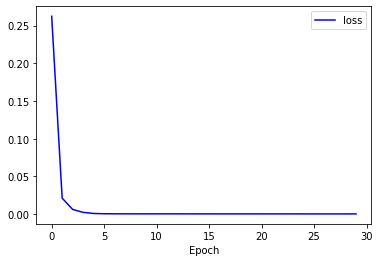

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

(529, 120, 1)


In [ ]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [ ]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    sell_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        sell_price.append(pred_array[idx, sell_time])
    sell_price = np.array(sell_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)*1 #-DACON-Bit_Trader폴더 주가 손실계산.png 참고
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forcasted_max = array_to_submission(pred_array_2d)

100%|██████████| 529/529 [00:00<00:00, 228129.43it/s]


In [ ]:
# final_submission csv파일로 저장
final_submission.to_csv('/content/drive/MyDrive/submission.csv', index = False)

In [ ]:
# 각 샘플의 예측치 중 최고값 모아 보기
forcasted_max

array([0.99507189, 1.01361847, 0.99641776, 1.01123595, 0.991063  ,
       1.03997993, 0.96475339, 0.97451049, 0.99224049, 0.99385267,
       1.03535283, 0.97588772, 1.01397943, 0.98737997, 0.9976486 ,
       1.01331222, 1.01645994, 1.00007248, 1.02457011, 1.02159822,
       1.01108658, 0.9892742 , 1.01900458, 1.00916982, 1.0269866 ,
       1.09272134, 1.01113355, 0.98868871, 0.99609339, 0.97841686,
       0.99115932, 1.02024162, 1.04315674, 0.98009539, 1.00250316,
       1.02870297, 0.98021477, 0.98198175, 1.01517761, 1.02309203,
       0.9586575 , 0.98862374, 0.99805599, 1.03001475, 0.9818753 ,
       1.01057267, 0.99699527, 1.00482416, 0.98745584, 1.03683269,
       1.03564894, 0.97389019, 1.01053274, 0.99684793, 0.98776382,
       0.97480929, 0.98296326, 0.99598867, 1.02158928, 0.99770868,
       0.98508292, 0.99248064, 1.0326128 , 0.99697924, 1.0113616 ,
       1.00040734, 0.97854322, 0.99270922, 1.01772916, 0.98241246,
       1.00530851, 1.02348757, 1.05048454, 0.9418214 , 0.98836

In [ ]:
# 전체 300가지 sample에 대해 _가지 case에서 (수수료 감안해서) 매수 시점(1380분)보다 108% 이상 상승한다고 추론함.
final_submission.buy_quantity.value_counts()

0    522
1      7
Name: buy_quantity, dtype: int64

In [ ]:
# (수수료 감안하지 않고) 매수 시점보다
forcasted_max[forcasted_max >= 1.08]

array([1.09272134, 1.08243155, 1.09532881, 1.12425423, 1.0806669 ,
       1.1564678 , 1.08455992, 1.12965035])

---

매수할 샘플이 너무 적게 나왔을 경우 기준치를 보고 10개 내외로 재조정

In [4]:
import numpy as np

forcasted_max = np.array([0.99507189, 1.01361847, 0.99641776, 1.01123595, 0.991063  ,
       1.03997993, 0.96475339, 0.97451049, 0.99224049, 0.99385267,
       1.03535283, 0.97588772, 1.01397943, 0.98737997, 0.9976486 ,
       1.01331222, 1.01645994, 1.00007248, 1.02457011, 1.02159822,
       1.01108658, 0.9892742 , 1.01900458, 1.00916982, 1.0269866 ,
       1.09272134, 1.01113355, 0.98868871, 0.99609339, 0.97841686,
       0.99115932, 1.02024162, 1.04315674, 0.98009539, 1.00250316,
       1.02870297, 0.98021477, 0.98198175, 1.01517761, 1.02309203,
       0.9586575 , 0.98862374, 0.99805599, 1.03001475, 0.9818753 ,
       1.01057267, 0.99699527, 1.00482416, 0.98745584, 1.03683269,
       1.03564894, 0.97389019, 1.01053274, 0.99684793, 0.98776382,
       0.97480929, 0.98296326, 0.99598867, 1.02158928, 0.99770868,
       0.98508292, 0.99248064, 1.0326128 , 0.99697924, 1.0113616 ,
       1.00040734, 0.97854322, 0.99270922, 1.01772916, 0.98241246,
       1.00530851, 1.02348757, 1.05048454, 0.9418214 , 0.98836231,
       1.00329483, 1.02818263, 1.01158464, 0.98227483, 1.08243155,
       0.98988312, 1.04972887, 1.01412022, 0.9867354 , 0.99070072,
       1.01017797, 0.96496058, 0.96539444, 0.95655727, 1.0311023 ,
       0.97104424, 1.01475775, 0.98617715, 0.98399431, 1.0005486 ,
       0.9932934 , 1.0237062 , 0.98761898, 1.01577854, 0.98455817,
       1.02619684, 0.9967705 , 1.09532881, 1.02419245, 0.99452066,
       1.02217126, 0.99302274, 1.03181577, 0.98272598, 1.01927602,
       0.99969929, 0.98594981, 1.01993895, 0.97703964, 1.02293599,
       1.03235555, 0.9665522 , 0.98107129, 1.04723477, 1.00822413,
       1.00647807, 0.98910111, 0.99511212, 1.06232119, 1.0456413 ,
       1.01138759, 1.02434862, 0.99922734, 0.9802748 , 0.96381736,
       0.98513454, 1.00346994, 1.00527215, 0.99439836, 0.99400914,
       0.9695273 , 0.97463262, 0.97747189, 0.99716276, 0.99268198,
       1.01751554, 1.02729189, 0.99695396, 0.96038419, 0.99182779,
       0.95834488, 0.99399889, 0.98373604, 0.99591374, 1.05237722,
       1.12425423, 0.98353696, 0.98885852, 0.97849816, 0.97305006,
       0.94589728, 0.97713155, 1.01908112, 1.03789711, 0.9690364 ,
       0.93879724, 1.00025594, 0.98103482, 0.99477327, 0.98180699,
       0.98481834, 0.97755438, 0.98368889, 1.03097904, 0.99580431,
       0.98382586, 0.98125672, 0.97057039, 0.96900451, 0.98949498,
       0.96514052, 1.01951289, 0.98879111, 1.00712454, 0.98446035,
       0.99001199, 1.01975584, 1.02786458, 0.99056643, 1.01268208,
       0.98611212, 1.00420141, 0.9886328 , 1.00078607, 1.0402385 ,
       0.98960692, 1.02980852, 1.01974177, 0.99048251, 0.97439092,
       0.99965894, 0.99883324, 1.0236243 , 0.98716122, 0.99051946,
       1.00511038, 1.02095616, 0.99458963, 1.03204596, 0.99104476,
       0.9709366 , 0.98753077, 0.99519396, 1.03351188, 1.02465522,
       0.99359679, 1.02964342, 0.97974753, 0.98534399, 0.9907366 ,
       0.97772723, 0.9909063 , 1.0755409 , 0.97661519, 0.97914219,
       0.97448868, 0.96652079, 1.00553942, 1.06059754, 1.03241587,
       1.00735915, 0.97196764, 1.01489866, 1.05841362, 0.97829986,
       1.02071857, 0.9671461 , 1.01738501, 0.98877615, 0.96579677,
       0.99433881, 0.98997253, 1.02866161, 0.99329966, 1.03578722,
       1.03101003, 1.01143086, 0.97958177, 0.97543037, 1.04128599,
       1.02628303, 0.9794715 , 1.05922318, 1.00116122, 0.95976388,
       1.01499248, 0.98790252, 0.97447968, 0.98952907, 0.99613887,
       0.97155941, 1.03477859, 0.95489979, 1.0806669 , 1.1564678 ,
       1.01367331, 1.06153297, 1.03397679, 0.99369925, 0.9969613 ,
       0.99160737, 1.05351973, 1.04177845, 1.03128898, 0.97274607,
       0.98685592, 0.99869686, 0.97836679, 0.98161453, 1.01427186,
       0.99658924, 1.01267719, 1.02582443, 0.9500941 , 0.96102262,
       1.01791465, 1.0292511 , 0.98211378, 1.01698399, 0.96525115,
       0.99583304, 0.98858303, 0.99825764, 0.99420106, 1.02859616,
       0.98860949, 0.97772205, 1.01681519, 1.01913512, 1.01908147,
       0.98687679, 0.98896301, 1.02741134, 0.97883803, 1.03043342,
       1.04498744, 1.0321281 , 0.9976185 , 0.99980509, 0.99519378,
       0.98337388, 1.02027762, 1.08455992, 0.98153758, 0.98810005,
       0.996333  , 1.0131669 , 1.04811203, 1.03748083, 0.98588687,
       0.9971689 , 1.00451386, 0.99107563, 0.98322356, 0.970842  ,
       0.95135719, 1.02245414, 0.95198298, 1.00807548, 1.014503  ,
       1.05190861, 1.00768375, 1.00146878, 0.98857278, 1.0210849 ,
       0.97093713, 1.00369656, 1.03123236, 0.98131603, 1.01603091,
       1.01129067, 1.01011705, 0.98227191, 0.9686991 , 1.04399741,
       1.00354218, 0.99317819, 1.01667023, 0.99490094, 1.02628219,
       1.01594031, 0.99523163, 1.04179466, 0.99026537, 1.02738965,
       1.00041866, 1.07300067, 0.9941501 , 1.04378259, 1.02348268,
       0.97579086, 0.99574029, 0.97923428, 0.98329157, 1.0013361 ,
       1.01053727, 1.00085533, 0.9576816 , 1.05171275, 0.9784438 ,
       0.99252719, 1.0295074 , 0.98500472, 0.99618918, 1.04486799,
       1.01429784, 1.00128555, 1.00034738, 0.99049813, 0.98447204,
       1.02851796, 1.00187302, 1.02283263, 1.00964272, 1.00136638,
       1.0504092 , 1.0308547 , 0.98614031, 1.02125776, 0.98892748,
       1.05547905, 1.0132277 , 1.00346339, 0.97158134, 0.98683846,
       1.00483584, 1.02936685, 0.98607647, 0.99234682, 0.99077189,
       0.98866689, 0.98126382, 1.00139213, 1.03216708, 0.97378325,
       0.96405375, 1.0468365 , 1.00614345, 0.98153669, 0.97512573,
       1.00544512, 0.98420155, 1.03531063, 1.12965035, 1.02285445,
       0.98069   , 1.0104239 , 1.06529057, 1.02516901, 0.98986763,
       1.0450294 , 1.05722308, 1.01174557, 0.97039402, 1.01361287,
       0.97118837, 0.9754687 , 1.0317049 , 0.98354197, 1.06915617,
       0.97773689, 0.97838724, 1.06203473, 1.05193138, 0.99771887,
       0.99776369, 1.01854491, 1.0204581 , 0.99521703, 1.01515687,
       0.98492074, 0.9792282 , 0.99039704, 0.98088855, 1.00620472,
       0.98964268, 1.00028634, 0.9777593 , 1.01766479, 1.0509845 ,
       1.00084436, 0.99973208, 1.01621425, 0.98226464, 1.02191377,
       0.99137449, 0.99105799, 1.00218415, 0.98655766, 1.06251931,
       0.98669749, 0.99103856, 1.07300591, 0.96826446, 0.99204677,
       1.02552354, 1.00243521, 0.98989826, 1.0291971 , 0.99333972,
       0.99948496, 1.04682136, 0.9994244 , 1.0323298 , 0.98309278,
       1.03594267, 0.9684006 , 1.04100323, 0.98311824, 1.04408813,
       0.96744096, 0.98215115, 0.98557657, 0.99139965, 0.99824214,
       0.94959241, 0.97953731, 1.01936615, 0.97116524, 0.99757528,
       0.99174345, 0.99140906, 1.00350833, 0.99626517, 0.99275512,
       0.97563535, 1.00335228, 0.97262269, 0.96299577, 0.99192721,
       1.03298175, 1.00259697, 1.0350467 , 0.99095583, 0.99036366,
       0.98968661, 1.00505638, 0.98118359, 0.99531031, 1.00549734,
       1.02529657, 1.01675463, 1.00993919, 0.97547787, 0.99015021,
       1.01344669, 0.99580896, 0.98249823, 1.00168204, 1.01098561,
       1.00970089, 0.99684715, 1.03691888, 1.00126922, 1.03236818,
       0.97557509, 1.05269516, 0.98363006, 1.0231564 , 1.00879276,
       1.00627625, 1.00735462, 0.99708927, 0.99154514])

In [5]:
len(forcasted_max)

529

In [7]:
l = []
for i in forcasted_max[forcasted_max>=1.10]:
    l.append(i)
l

[1.12425423, 1.1564678, 1.12965035]

In [8]:
for j in l:
    print(np.where(forcasted_max == j))

(array([150]),)
(array([259]),)
(array([408]),)


---

In [ ]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 70  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, min_lr = 0)

# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
ep = 30
bs = 120
for idx in range(sample, sample+1):
    seq_len = 60  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop, reduceLR])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력
    
    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Epoch 1/30
10/10 - 5s - loss: 0.2978 - mse: 0.2978 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 2/30
10/10 - 0s - loss: 0.0204 - mse: 0.0204 - val_loss: 5.5739e-06 - val_mse: 5.5739e-06
Epoch 3/30
10/10 - 0s - loss: 0.0061 - mse: 0.0061 - val_loss: 5.0151e-04 - val_mse: 5.0151e-04
Epoch 4/30
10/10 - 0s - loss: 0.0024 - mse: 0.0024 - val_loss: 2.6832e-06 - val_mse: 2.6832e-06
Epoch 5/30
10/10 - 0s - loss: 7.9853e-04 - mse: 7.9853e-04 - val_loss: 1.2142e-04 - val_mse: 1.2142e-04
Epoch 6/30
10/10 - 0s - loss: 6.7496e-05 - mse: 6.7496e-05 - val_loss: 1.9205e-04 - val_mse: 1.9205e-04
Epoch 7/30
10/10 - 0s - loss: 5.3538e-05 - mse: 5.3538e-05 - val_loss: 9.0396e-05 - val_mse: 9.0396e-05
Epoch 8/30
10/10 - 0s - loss: 1.4056e-05 - mse: 1.4056e-05 - val_loss: 2.7919e-05 - val_mse: 2.7919e-05
Epoch 9/30
10/10 - 0s - loss: 1.0043e-05 - mse: 1.0043e-05 - val_loss: 2.6436e-05 - val_mse: 2.6436e-05
Epoch 10/30
10/10 - 0s - loss: 1.0139e-05 - mse: 1.0139e-05 - val_loss: 2.6470e-05 - val_mse: 2.6470e-05

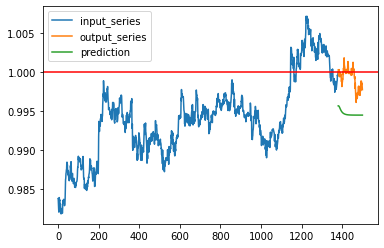

In [ ]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

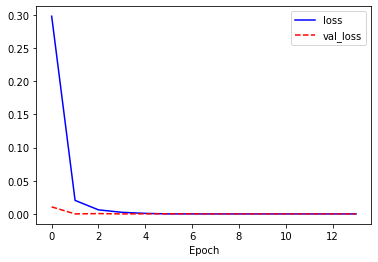

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

---

In [ ]:
# train_x_df의 자료들을 학습에 활용하게 될 경우:
# train_x_df를 sample_id을 기준으로 추출하는 방법
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]